# Resource usage - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v3", "*", "file.parquet")

In [4]:
# import internal packages
sys.path.append(src_dir)
from data.gas_cost import compute_component_gas_costs_per_tx
from resource_gas_split import compute_resource_gas_cost_per_tx

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22001999.

In [5]:
# Load parquet files with duckdb
query = f"""
SELECT *
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    union_by_name=True
    )
WHERE block_height BETWEEN 22000000 AND 22001999;
"""
agg_trace_df = duckdb.connect().execute(query).fetchdf()
# Drop columns
agg_trace_df = agg_trace_df.drop(columns=["block_range"])
# Clean up repeated opcodes
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("DUP"), "DUP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    agg_trace_df["op"].str.startswith("SWAP"), "SWAP", agg_trace_df["op"]
)
agg_trace_df["op"] = np.where(
    (agg_trace_df["op"].str.startswith("PUSH")) & (agg_trace_df["op"] != "PUSH0"),
    "PUSH",
    agg_trace_df["op"],
)
# Compute total gas cost for opcode
agg_trace_df["op_total_gas_cost"] = (
    agg_trace_df["op_gas_cost"] * agg_trace_df["op_gas_pair_count"]
)
# Print info
agg_trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27433638 entries, 0 to 27433637
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   op                 object 
 3   op_gas_cost        float64
 4   post_memory_size   int64  
 5   memory_expansion   int64  
 6   memory_size        int64  
 7   cum_refund         int64  
 8   call_address       object 
 9   op_gas_pair_count  int64  
 10  op_total_gas_cost  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 2.2+ GB


In [6]:
agg_trace_df["block_height"].agg(["min", "max"])

min    22000000
max    22001999
Name: block_height, dtype: int64

Now, we can load the gas used per transaction.

In [7]:
# Load parquet file
tx_gas_info_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Make sure we don't more blocks than agg_trace_df
tx_gas_info_df = tx_gas_info_df[
    tx_gas_info_df["block_height"].between(
        agg_trace_df["block_height"].min(), agg_trace_df["block_height"].max()
    )
]
# Print info
tx_gas_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290953 entries, 0 to 290952
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   block_height            290953 non-null  int64 
 1   tx_hash                 290953 non-null  object
 2   tx_gas_cost             290953 non-null  int64 
 3   tx_gas_limit            290953 non-null  int64 
 4   tx_input_zero_bytes     290953 non-null  int64 
 5   tx_input_nonzero_bytes  290953 non-null  int64 
 6   tx_input_data_cost      290953 non-null  int64 
 7   is_contract_creation    290953 non-null  bool  
 8   is_success              290953 non-null  bool  
dtypes: bool(2), int64(6), object(1)
memory usage: 18.3+ MB


## 3. Process data

In [8]:
# Compute gas costs by component
comp_df = compute_component_gas_costs_per_tx(agg_trace_df, tx_gas_info_df)
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290953 entries, 0 to 290952
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   block_height           290953 non-null  int64  
 1   tx_hash                290953 non-null  object 
 2   total_gas_cost         290953 non-null  int64  
 3   input_data_cost        290953 non-null  int64  
 4   intrinsic_base_cost    290953 non-null  float64
 5   op_gas_cost            290953 non-null  float64
 6   gas_refund             290953 non-null  float64
 7   intrinsic_access_cost  290953 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 17.8+ MB


In [9]:
# How many transactions with strange intrinsic access costs?
strange_access_txs = comp_df[~comp_df["intrinsic_access_cost"].between(0, 4000000)][
    "tx_hash"
].values.tolist()
gas_perc = (
    comp_df[comp_df["tx_hash"].isin(strange_access_txs)]["total_gas_cost"].sum()
) / (comp_df["total_gas_cost"].sum())

print("tx %:", np.round(100 * len(strange_access_txs) / len(comp_df), 2))
print("gas %:", np.round(gas_perc * 100, 2))

tx %: 0.18
gas %: 1.38


In [10]:
# How many failed transactions?
fail_txs = tx_gas_info_df[~tx_gas_info_df["is_success"]]["tx_hash"].values.tolist()
gas_perc = (comp_df[comp_df["tx_hash"].isin(fail_txs)]["total_gas_cost"].sum()) / (
    comp_df["total_gas_cost"].sum()
)

print("tx %:", np.round(100 * len(fail_txs) / len(comp_df), 2))
print("gas %:", np.round(gas_perc * 100, 2))

tx %: 1.71
gas %: 1.74


In [11]:
# Compute gas cost by resource
# fail_txs and strange_access_txs are unassigned...
ignore_txs = fail_txs + strange_access_txs
gas_by_resource_df = compute_resource_gas_cost_per_tx(
    agg_trace_df,
    tx_gas_info_df,
    comp_df,
    fail_txs,
)
gas_by_resource_df.head()

,tx_hash,Compute,Access,Memory,History,Bloom topics,State,Bandwidth,Unassigned,block_height,State (exc. Refunds)
0,0x00003ef2732f7a5fae9e941735730033b0b9158f352d...,12192.0,12800.0,24.0,7646.0,750.0,800.0,6148.0,0.0,22000219.0,5600.0
1,0x0000660566258dcad219705056675861f779e7726e52...,15616.0,2800.0,24.0,7908.0,250.0,0.0,6052.0,0.0,22000622.0,0.0
2,0x000090840558d73b755fa6520b6b14e4a0e477db8608...,8500.0,300.0,0.0,6500.0,0.0,0.0,5700.0,0.0,22001353.0,0.0
3,0x0000d156c77b4b2cd777dded82d69a38173ff5d7fc4d...,8500.0,300.0,0.0,6500.0,0.0,0.0,5700.0,0.0,22000783.0,0.0
4,0x00016a4bd16a81c927552beb290952430b7a22dd7d39...,34468.0,35900.0,316.0,10829.5,2250.0,19600.0,6716.5,0.0,22000326.0,42300.0


In [12]:
# Melt (for plotting)
melt_gas_by_resource_df = gas_by_resource_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="Resource", value_name="gas_cost"
).sort_values("Resource")

melt_gas_by_resource_df.head()

,block_height,tx_hash,Resource,gas_cost
436429,22001155.0,0x7ff06c8439b40a86f85d24aef212aa0c5d54e05b7237...,Access,36300.0
387947,22001313.0,0x558fb0c62d82f427377596ca9d0c45d6c72d9dea6ffc...,Access,83500.0
387946,22001458.0,0x558fa33494a03d59746e23ed11e5f70fe5f3bedeb7d0...,Access,300.0
387945,22001173.0,0x558f9743f9b1b01237bda5ddb2b978b5abf833ff7eb1...,Access,11800.0
387944,22000968.0,0x558f83c91811ffaaf97c7a10fdfb626780b7c3f76493...,Access,300.0


## 4. Analyze gas by resource

In [13]:
# Transactions with unassigned gas
total_gas = (
    gas_by_resource_df.drop(columns=["tx_hash", "block_height", "State (exc. Refunds)"])
    .sum(axis=1)
    .sum()
)
print(
    "Txs %:", 100 * sum(gas_by_resource_df["Unassigned"] > 0) / len(gas_by_resource_df)
)
print("Gas:", gas_by_resource_df["Unassigned"].sum())
print("Gas %:", 100 * gas_by_resource_df["Unassigned"].sum() / total_gas)

Txs %: 1.706117482892426
Gas: 641605963.0
Gas %: 1.7423115753987064


In [14]:
# What percentage of transactions have a positive intrinsic costs?
100 * sum(comp_df["intrinsic_access_cost"] > 0) / len(comp_df)

8.606888397782459

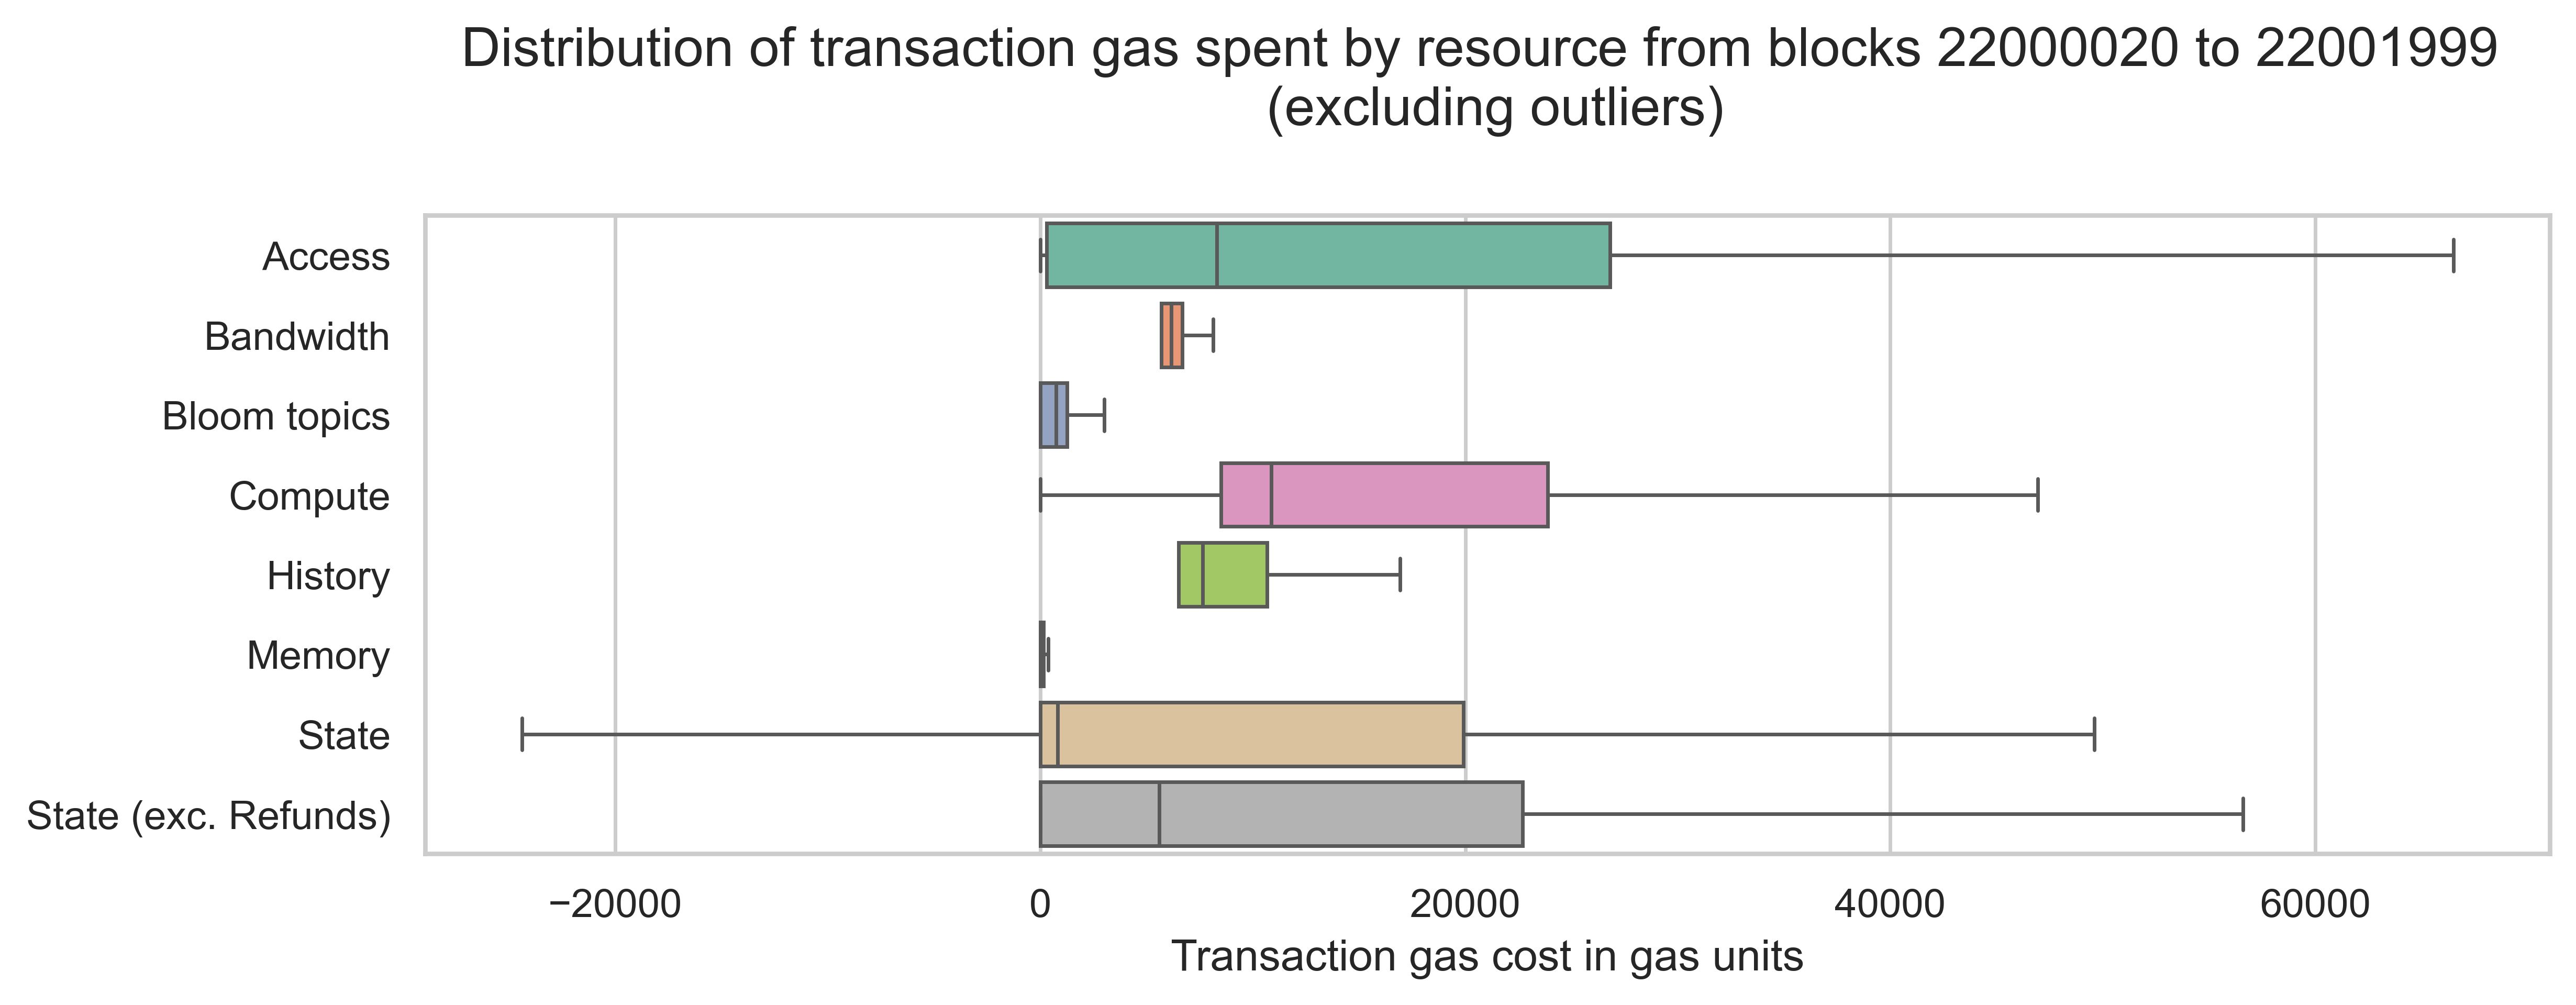

In [15]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=melt_gas_by_resource_df[melt_gas_by_resource_df["Resource"] != "Unassigned"],
    hue="Resource",
    legend=False,
    showfliers=False,
)
plt.title(
    "Distribution of transaction gas spent by resource from blocks 22000020 to 22001999 \n (excluding outliers)",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Transaction gas cost in gas units")
plt.tight_layout()
plt.show()

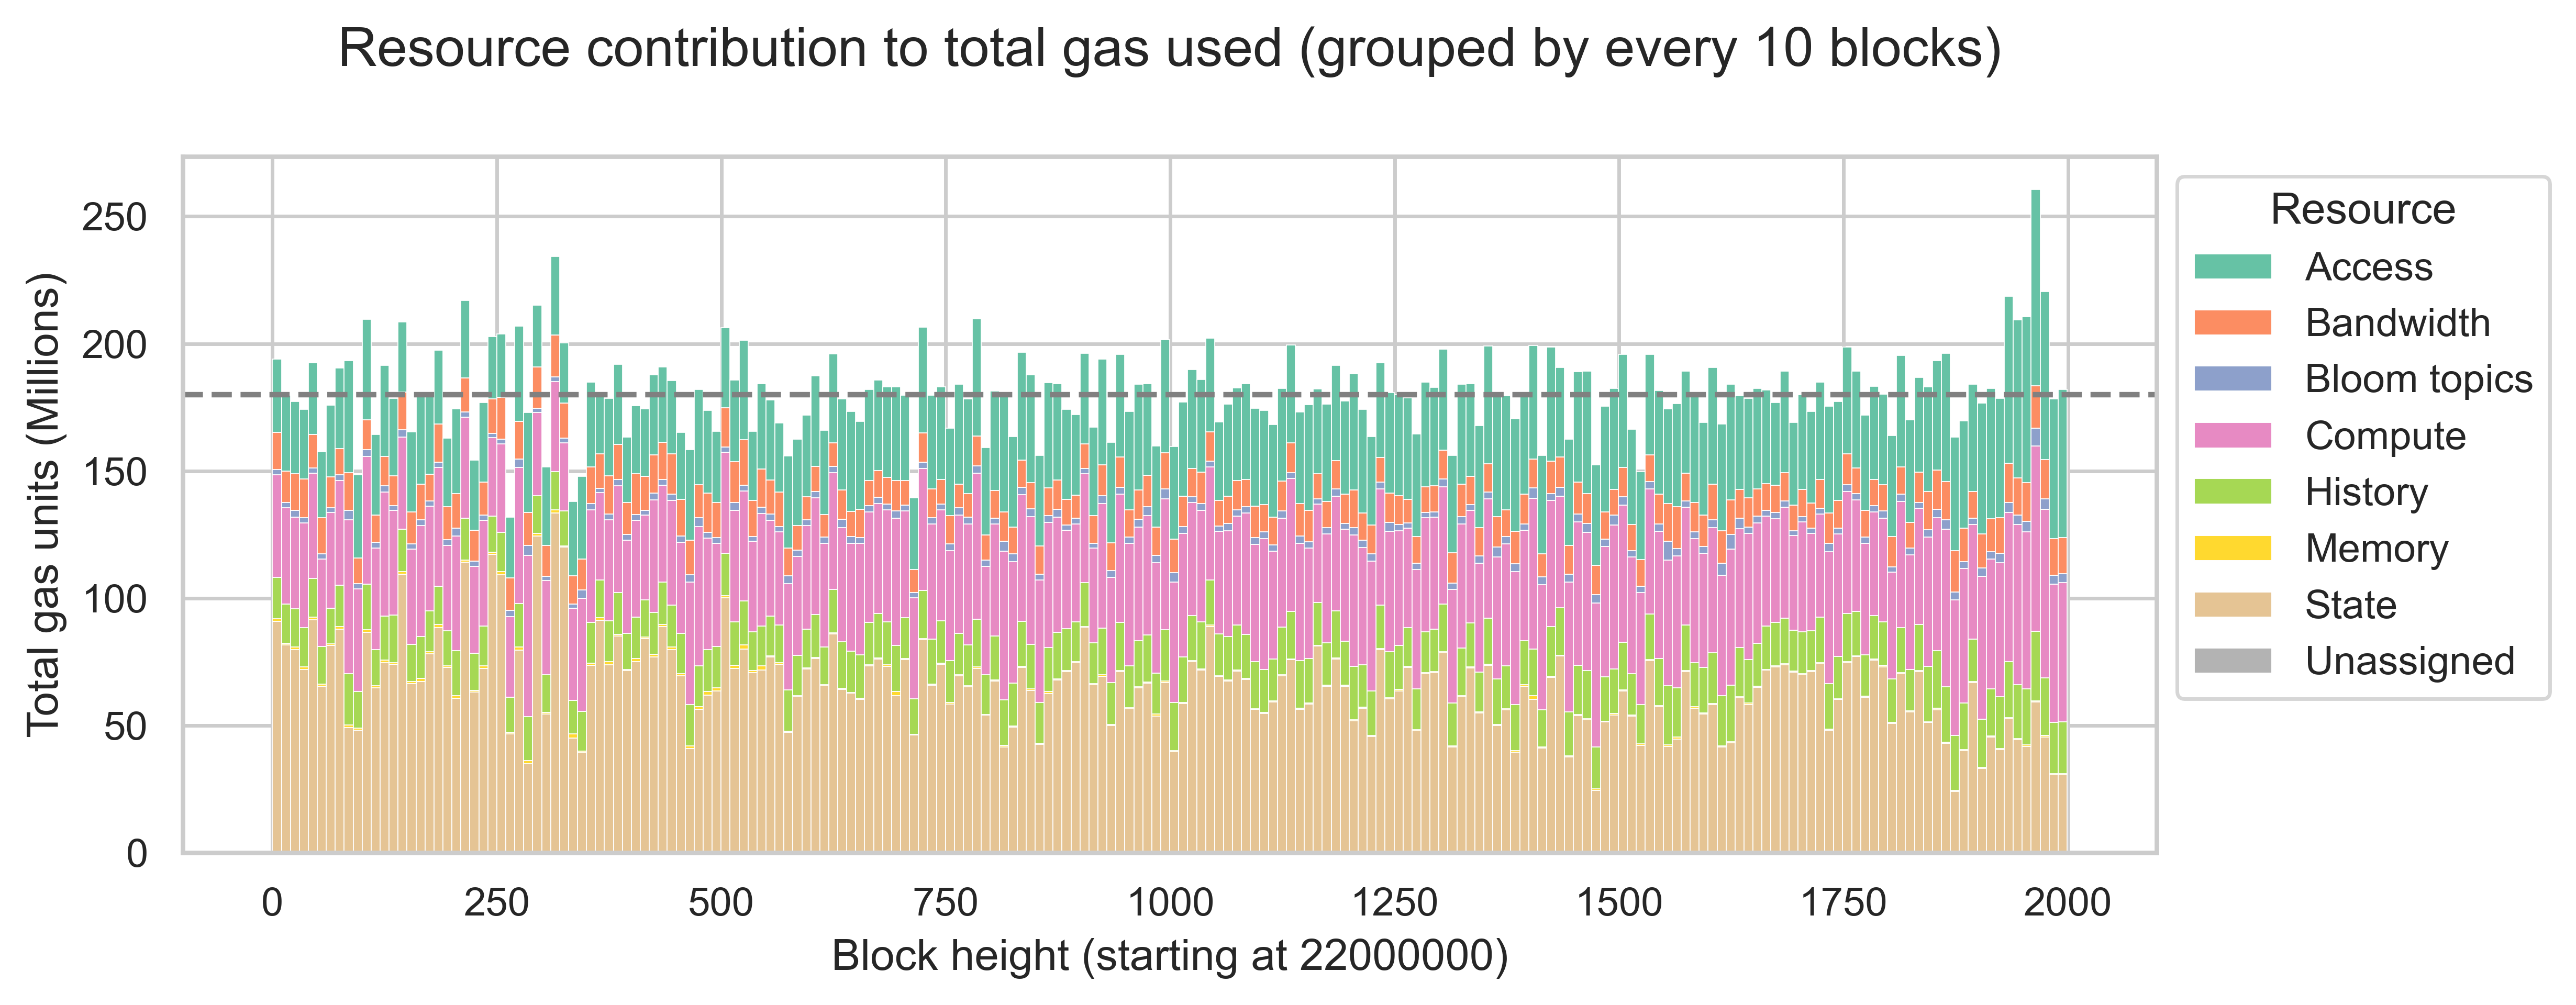

In [16]:
temp_df = (
    melt_gas_by_resource_df[
        melt_gas_by_resource_df["Resource"] != "State (exc. Refunds)"
    ]
    .groupby(["block_height", "Resource"])["gas_cost"]
    .sum()
    / 1_000_000
)
temp_df = temp_df.reset_index().sort_values("Resource")
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax = sns.histplot(
    temp_df,
    x="block_height",
    weights="gas_cost",
    hue="Resource",
    multiple="stack",
    binwidth=10,
    alpha=1.0,
)
plt.title(
    "Resource contribution to total gas used (grouped by every 10 blocks)",
    pad=25,
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.axhline(y=180, color="grey", linestyle="--", label="target block size")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [17]:
temp_df = (
    melt_gas_by_resource_df[
        melt_gas_by_resource_df["Resource"] != "State (exc. Refunds)"
    ]
    .groupby(["Resource"])["gas_cost"]
    .sum()
    / 1_000_000
)
print(temp_df.sort_values(ascending=False))
print(temp_df.sort_values(ascending=False) / temp_df.sum())

Resource
State           13083.354470
Compute          9076.041733
Access           7492.638935
History          3446.934015
Bandwidth        2424.854798
Unassigned        641.605963
Bloom topics      541.835250
Memory            117.719073
Name: gas_cost, dtype: float64
Resource
State           0.355285
Compute         0.246464
Access          0.203466
History         0.093603
Bandwidth       0.065848
Unassigned      0.017423
Bloom topics    0.014714
Memory          0.003197
Name: gas_cost, dtype: float64


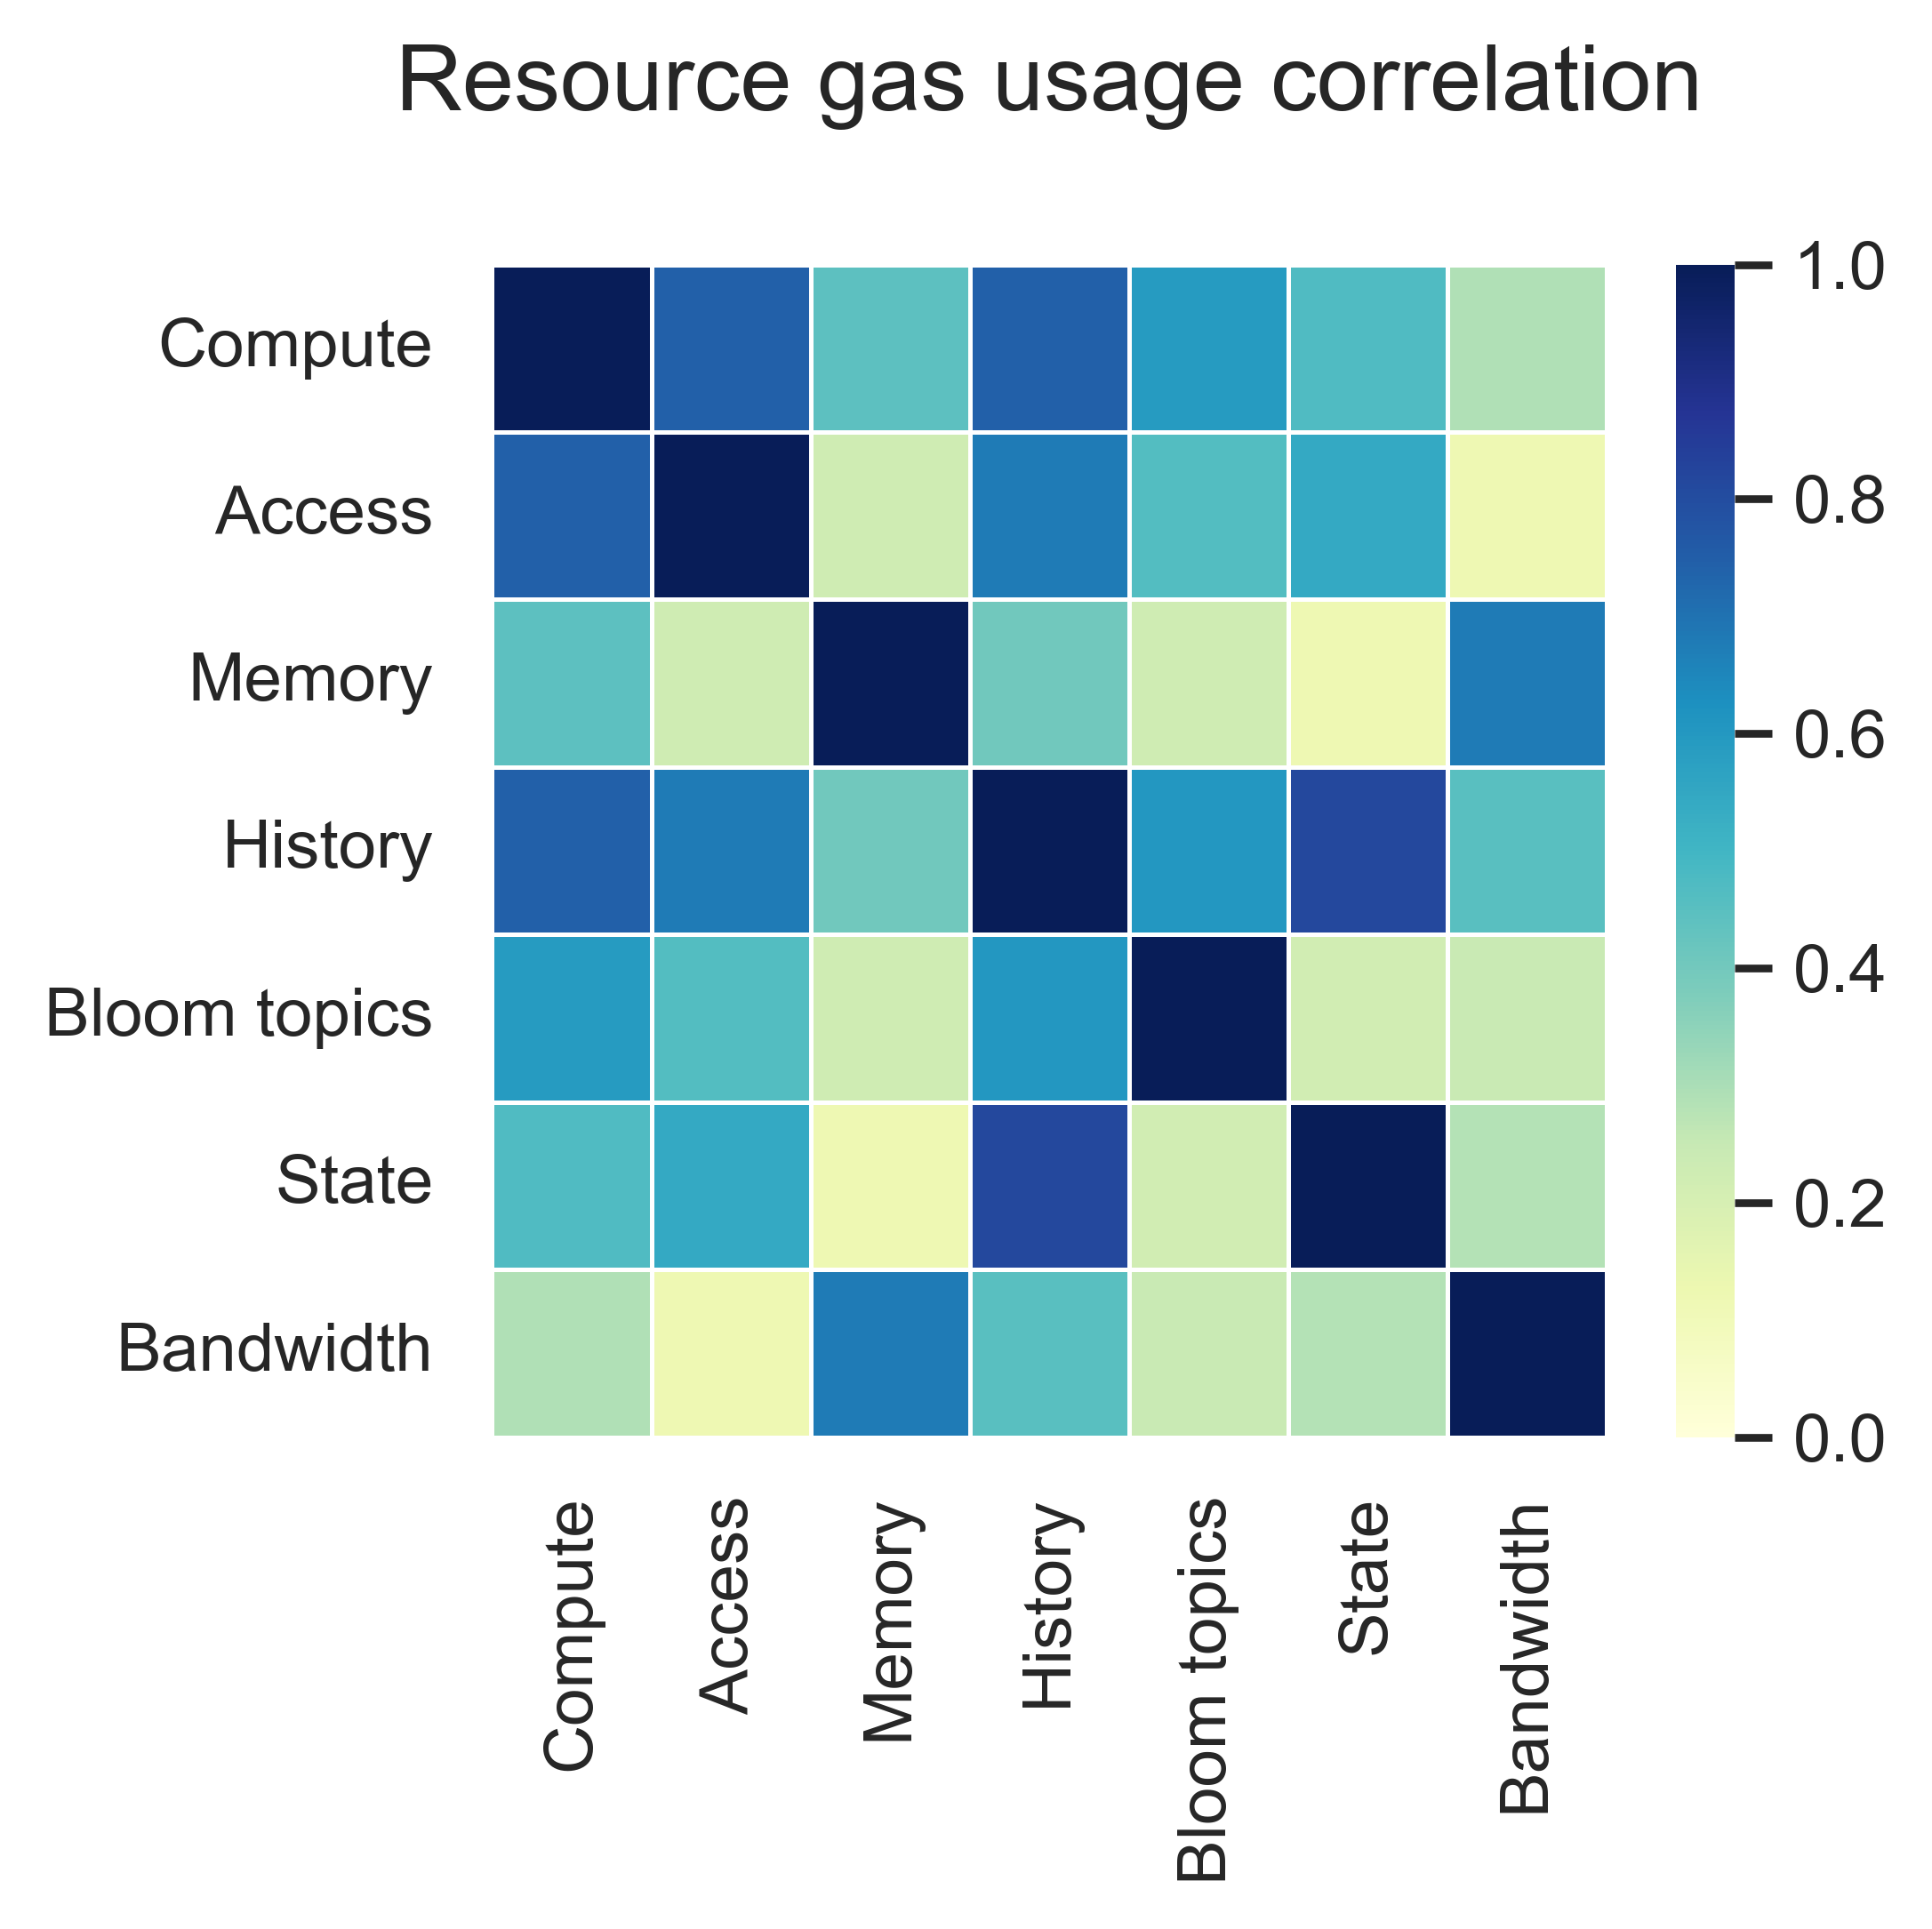

In [18]:
temp_df = gas_by_resource_df.drop(
    columns=["block_height", "Unassigned", "State (exc. Refunds)"]
).set_index("tx_hash")
corr_mat = temp_df.corr()
plt.figure(figsize=(4.5, 4.5))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5, vmin=0, vmax=1)
plt.title("Resource gas usage correlation", pad=25)
plt.tight_layout()
plt.show()

## 5. Analyze block utilization

In [19]:
totals_df = (
    gas_by_resource_df.drop(columns=["tx_hash", "State (exc. Refunds)"])
    .groupby("block_height")
    .sum()
)
totals_df.head()

,Compute,Access,Memory,History,Bloom topics,State,Bandwidth,Unassigned
block_height,,,,,,,,
22000000.0,2489521.0,2388848.0,38438.0,1234279.5,149500.0,11582506.0,1252477.5,0.0
22000001.0,6641783.0,2759899.0,330132.0,2071252.0,267750.0,1932300.0,2258159.0,0.0
22000002.0,3271744.0,2827479.0,50038.0,1264452.0,173250.0,9393240.0,1154862.0,0.0
22000003.0,3979104.0,2997615.0,24050.0,1647246.0,185250.0,2215800.0,1314686.0,0.0
22000004.0,2635728.0,1886444.0,40126.0,1578321.5,149000.0,18424296.0,1293454.5,0.0


In [20]:
# One dimensional metering
one_dim_df = totals_df.sum(axis=1).reset_index()
one_dim_df.columns = ["block_height", "usage"]
one_dim_df["perc_over_limit"] = one_dim_df["usage"] / 36_000_000
one_dim_df["utilization"] = (one_dim_df["usage"] - 18_000_000) / 18_000_000
one_dim_df["meter"] = "Unidimensional"
one_dim_df = one_dim_df.reset_index()

# Two dimensional -  State & History vs. others
two_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "others": totals_df.sum(axis=1) - totals_df["State"] - totals_df["History"],
    }
)
two_dim_df["usage"] = two_dim_df.max(axis=1)
two_dim_df["perc_over_limit"] = two_dim_df["usage"] / 36_000_000
two_dim_df["utilization"] = (two_dim_df["usage"] - 18_000_000) / 18_000_000
two_dim_df["meter"] = "State/history vs. Others"
two_dim_df = two_dim_df.reset_index()

# Two dimensional -  State & History vs. Storage Access vs. others
three_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "access": totals_df["Access"],
        "others": totals_df.sum(axis=1)
        - totals_df["State"]
        - totals_df["History"]
        - totals_df["Access"],
    }
)
three_dim_df["usage"] = three_dim_df.max(axis=1)
three_dim_df["perc_over_limit"] = three_dim_df["usage"] / 36_000_000
three_dim_df["utilization"] = (three_dim_df["usage"] - 18_000_000) / 18_000_000
three_dim_df["meter"] = "State/history vs. Access vs. Others"
three_dim_df = three_dim_df.reset_index()

# Aggregate all dataframes
util_melt_df = pd.concat(
    [
        one_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
        two_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
        three_dim_df[
            ["block_height", "meter", "usage", "perc_over_limit", "utilization"]
        ],
    ],
    ignore_index=True,
)
util_melt_df.head()

,block_height,meter,usage,perc_over_limit,utilization
0,22000000.0,Unidimensional,19135570.0,0.531544,0.063087
1,22000001.0,Unidimensional,16261275.0,0.451702,-0.096596
2,22000002.0,Unidimensional,18135065.0,0.503752,0.007504
3,22000003.0,Unidimensional,12363751.0,0.343438,-0.313125
4,22000004.0,Unidimensional,26007370.0,0.722427,0.444854


In [21]:
((two_dim_df["usage"] - one_dim_df["usage"]) / one_dim_df["usage"]).agg(
    ["mean", "median"]
)

mean     -0.321946
median   -0.307238
Name: usage, dtype: float64

In [22]:
((three_dim_df["usage"] - two_dim_df["usage"]) / two_dim_df["usage"]).agg(
    ["mean", "median"]
)

mean     -0.254929
median   -0.347920
Name: usage, dtype: float64

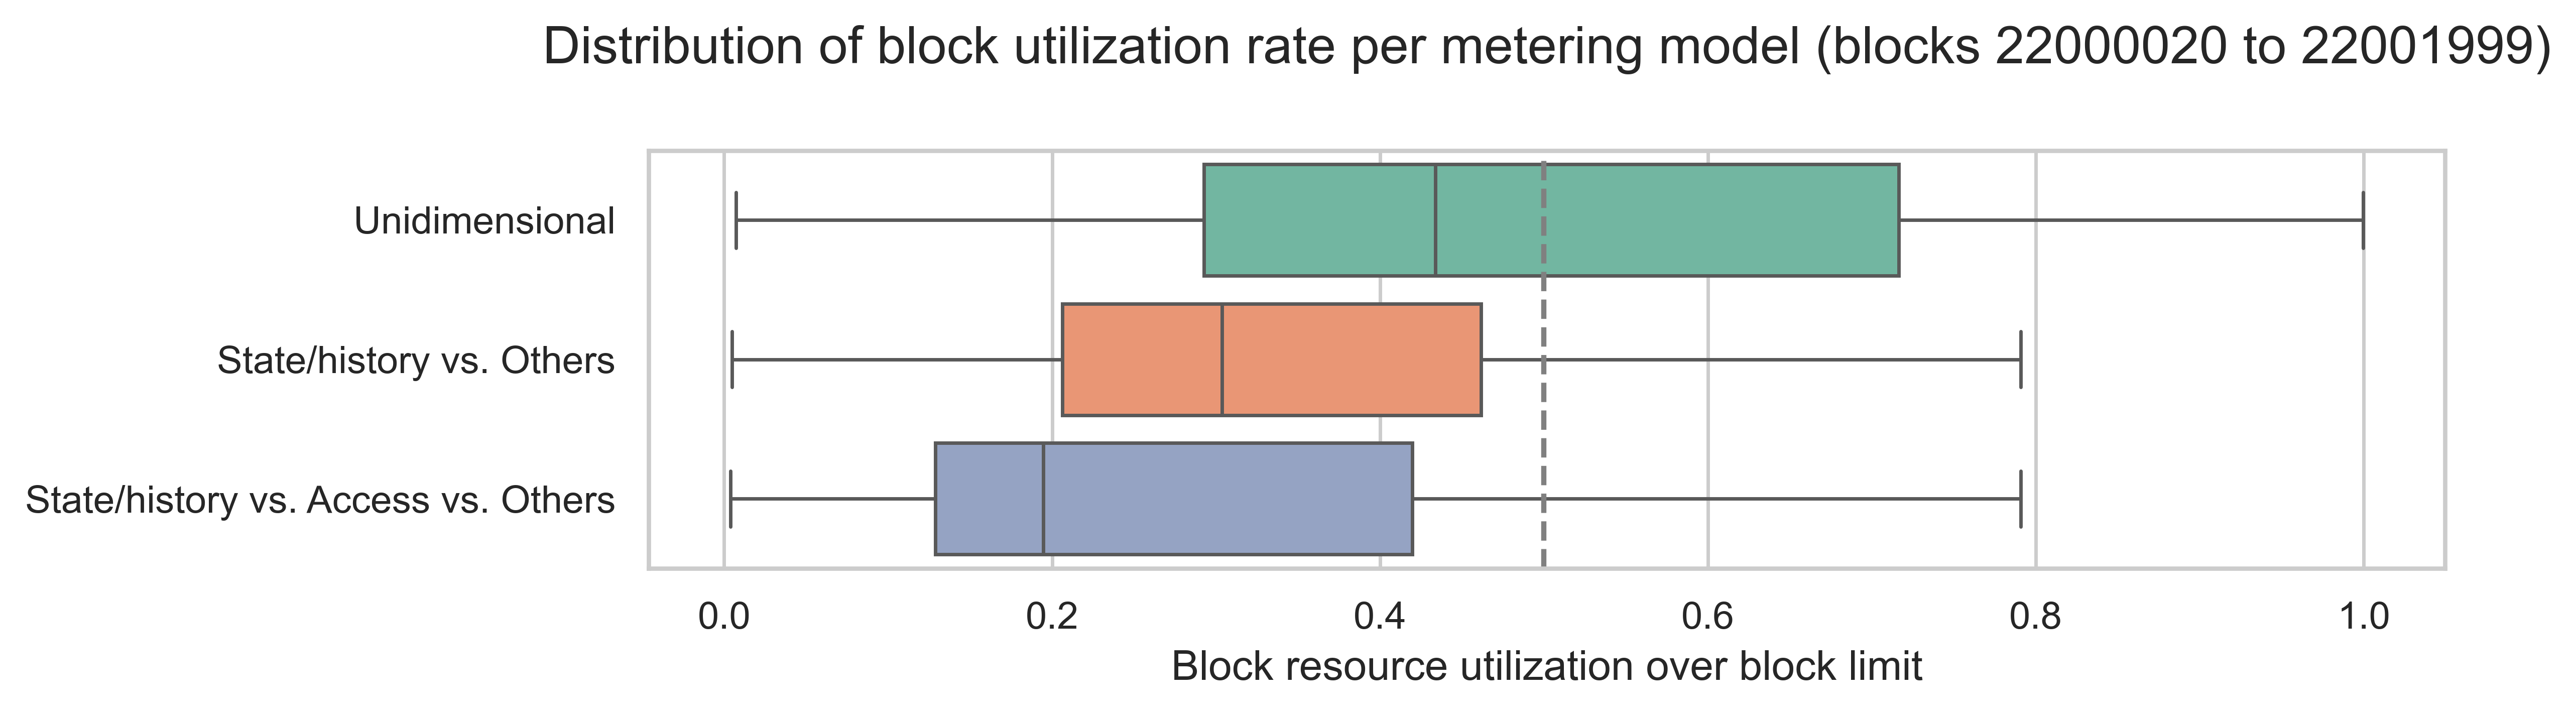

In [23]:
plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df,
    x="perc_over_limit",
    y="meter",
    hue="meter",
    legend=False,
)
plt.axvline(x=0.5, color="grey", linestyle="--")
plt.xlabel("Block resource utilization over block limit")
plt.ylabel("")
plt.title(
    "Distribution of block utilization rate per metering model (blocks 22000020 to 22001999)",
    pad=25,
)
plt.tight_layout()
plt.show()

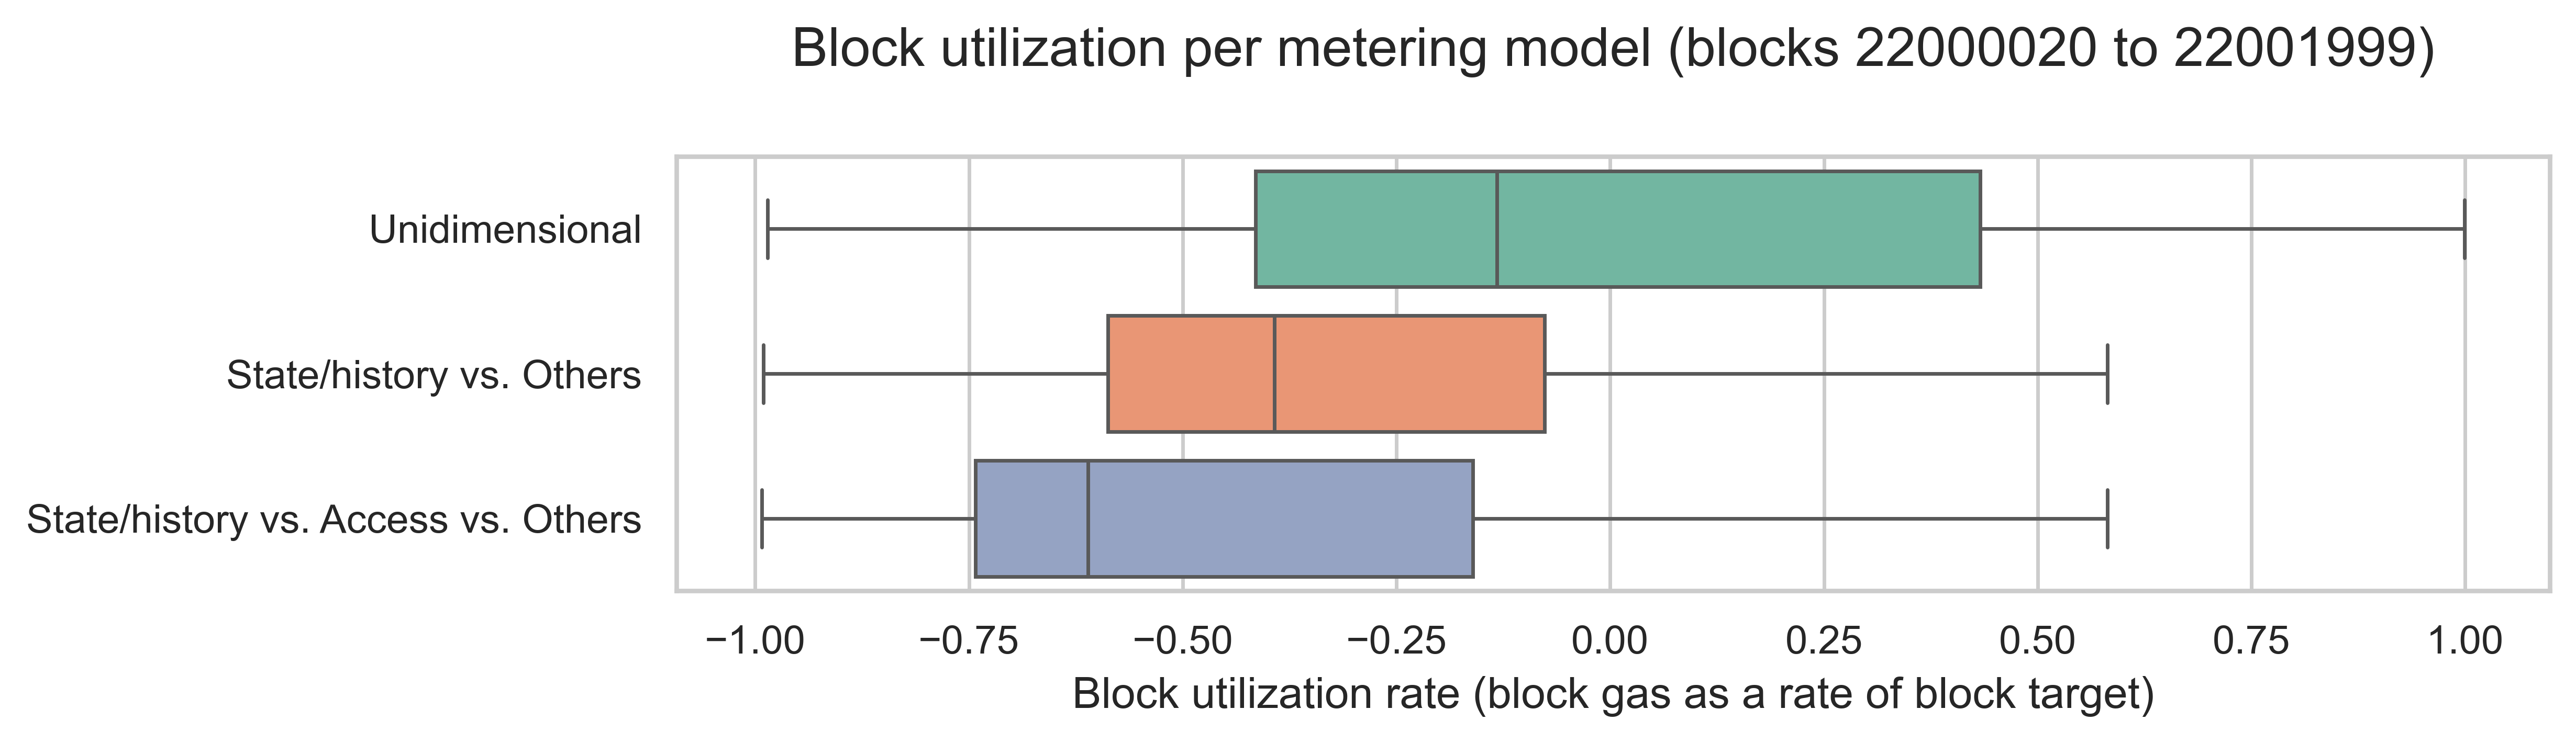

In [24]:
plt.figure(figsize=(10, 3))
sns.boxplot(
    data=util_melt_df,
    x="utilization",
    y="meter",
    hue="meter",
    legend=False,
)
plt.xlabel("Block utilization rate (block gas as a rate of block target)")
plt.ylabel("")
plt.title("Block utilization per metering model (blocks 22000020 to 22001999)", pad=25)
plt.tight_layout()
plt.show()

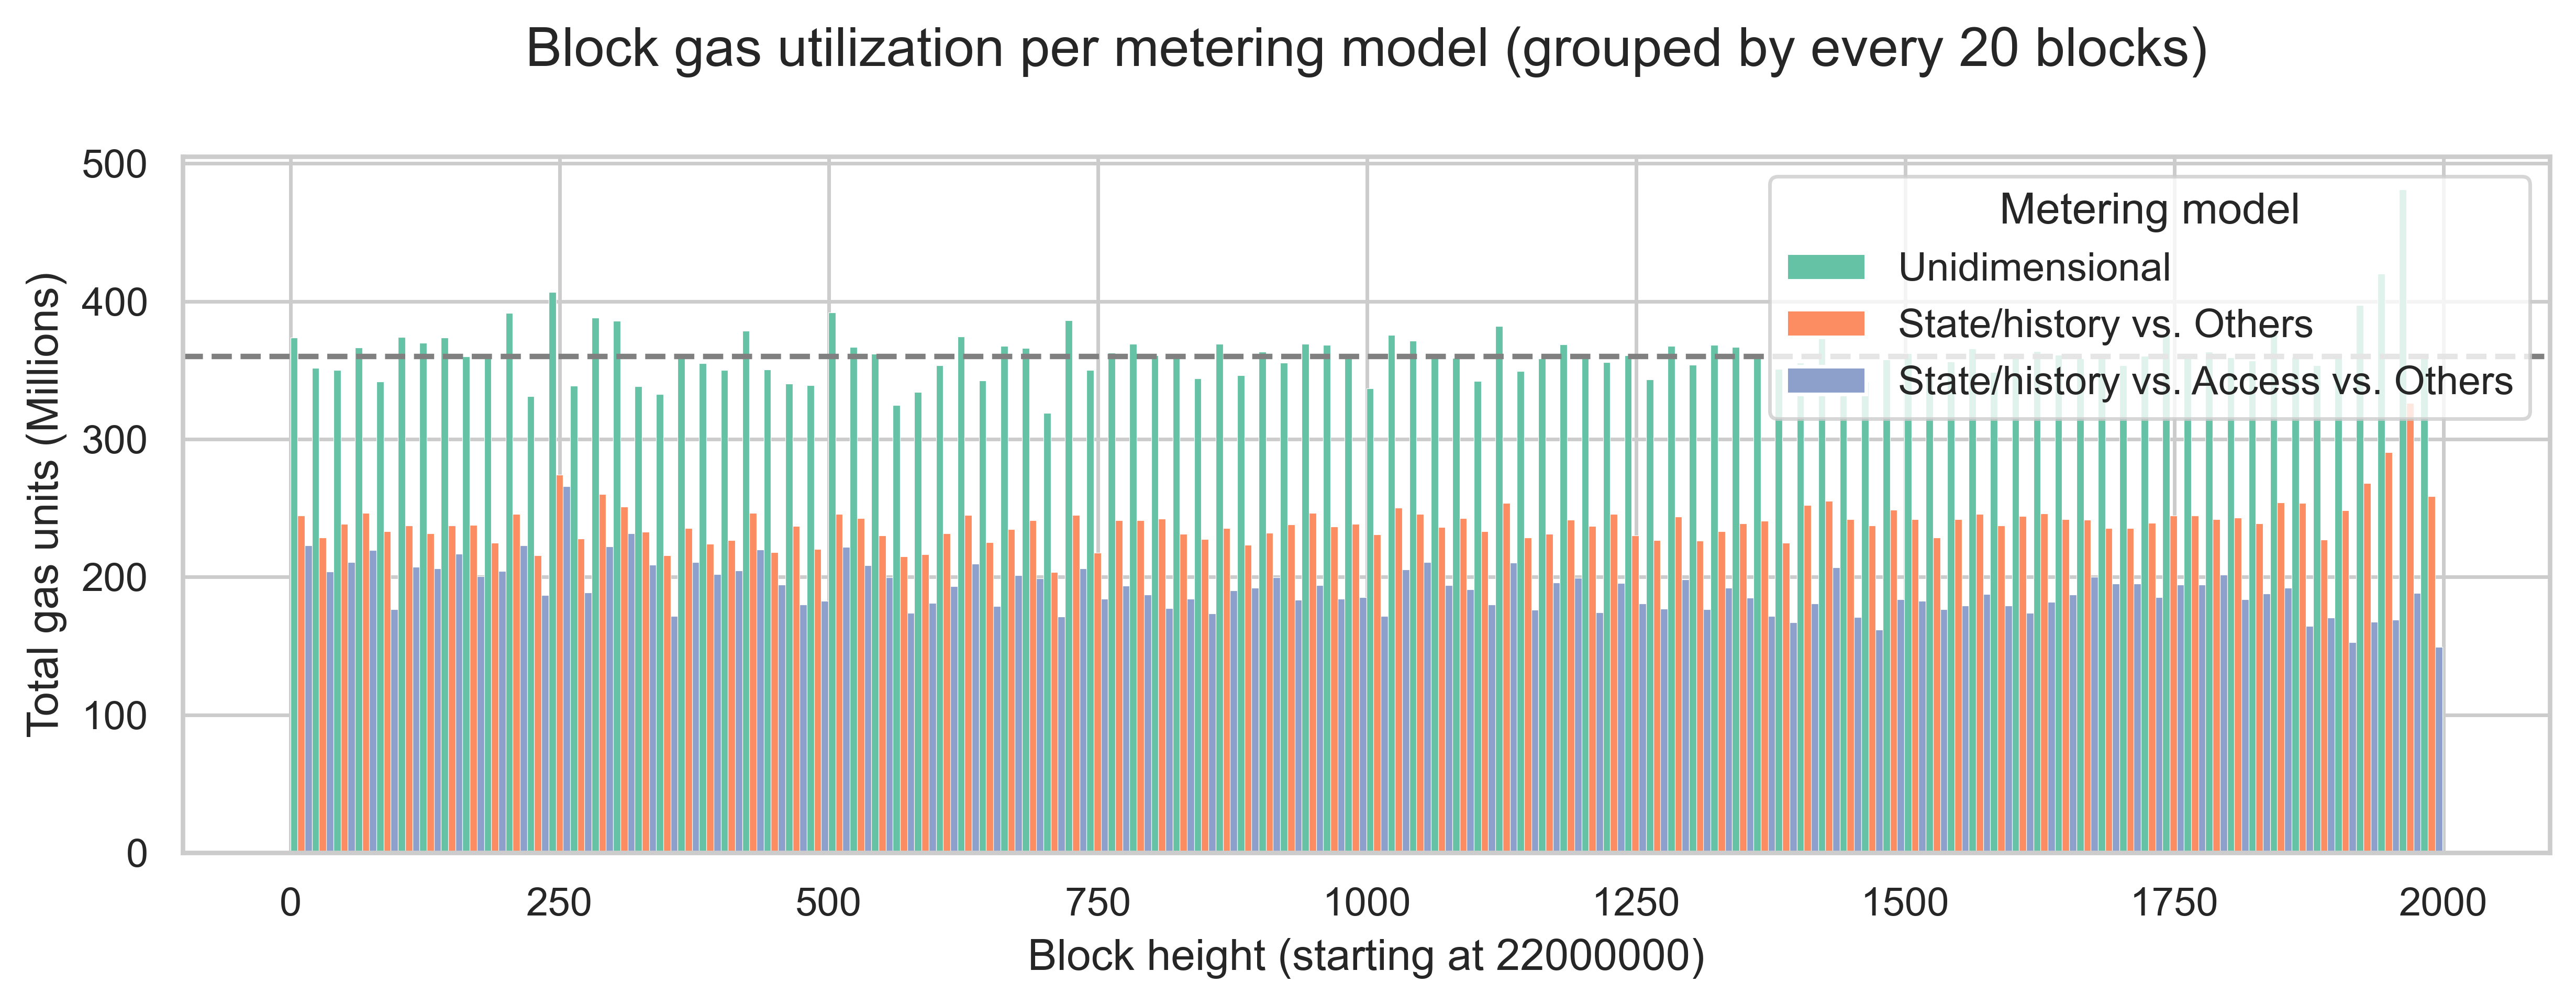

In [25]:
temp_df = util_melt_df.rename(columns={"meter": "Metering model"}).copy()
temp_df["usage"] = temp_df["usage"] / 1_000_000
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax = sns.histplot(
    temp_df,
    x="block_height",
    weights="usage",
    hue="Metering model",
    multiple="dodge",
    binwidth=20,
    alpha=1.0,
)
plt.title(
    "Block gas utilization per metering model (grouped by every 20 blocks)",
    pad=25,
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.axhline(y=180 * 2, color="grey", linestyle="--", label="target block size")

plt.tight_layout()
plt.show()

## 6. Analyze resource utilization

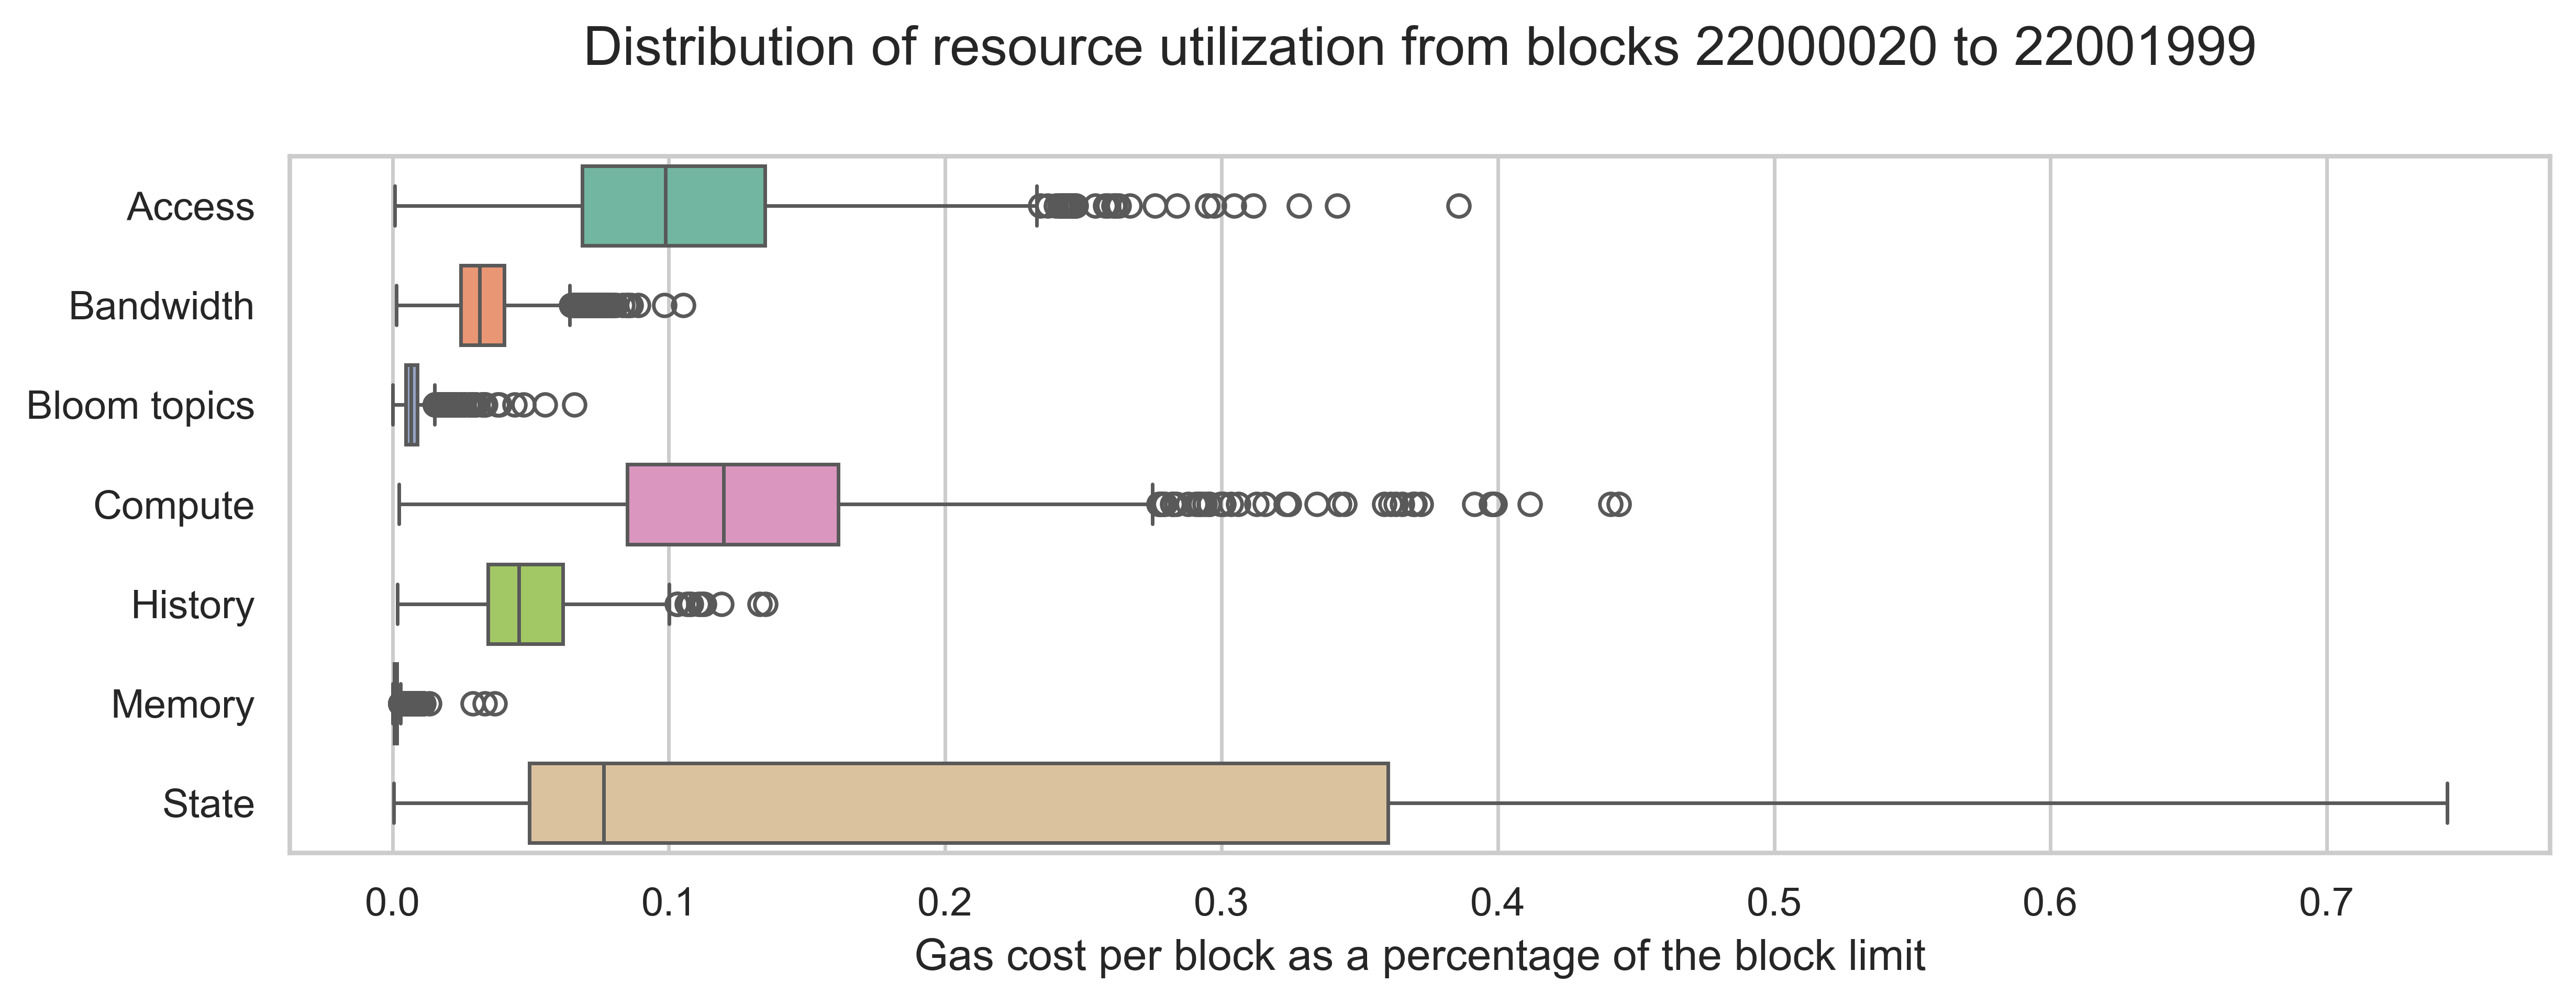

In [26]:
temp_df = (
    melt_gas_by_resource_df[
        ~melt_gas_by_resource_df["Resource"].isin(["Unassigned", "State (exc. Refunds)"])
    ]
    .groupby(["block_height", "Resource"])["gas_cost"]
    .sum()
    .reset_index()
)
temp_df["gas_cost"] = temp_df["gas_cost"] / 36_000_000

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    "Distribution of resource utilization from blocks 22000020 to 22001999",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

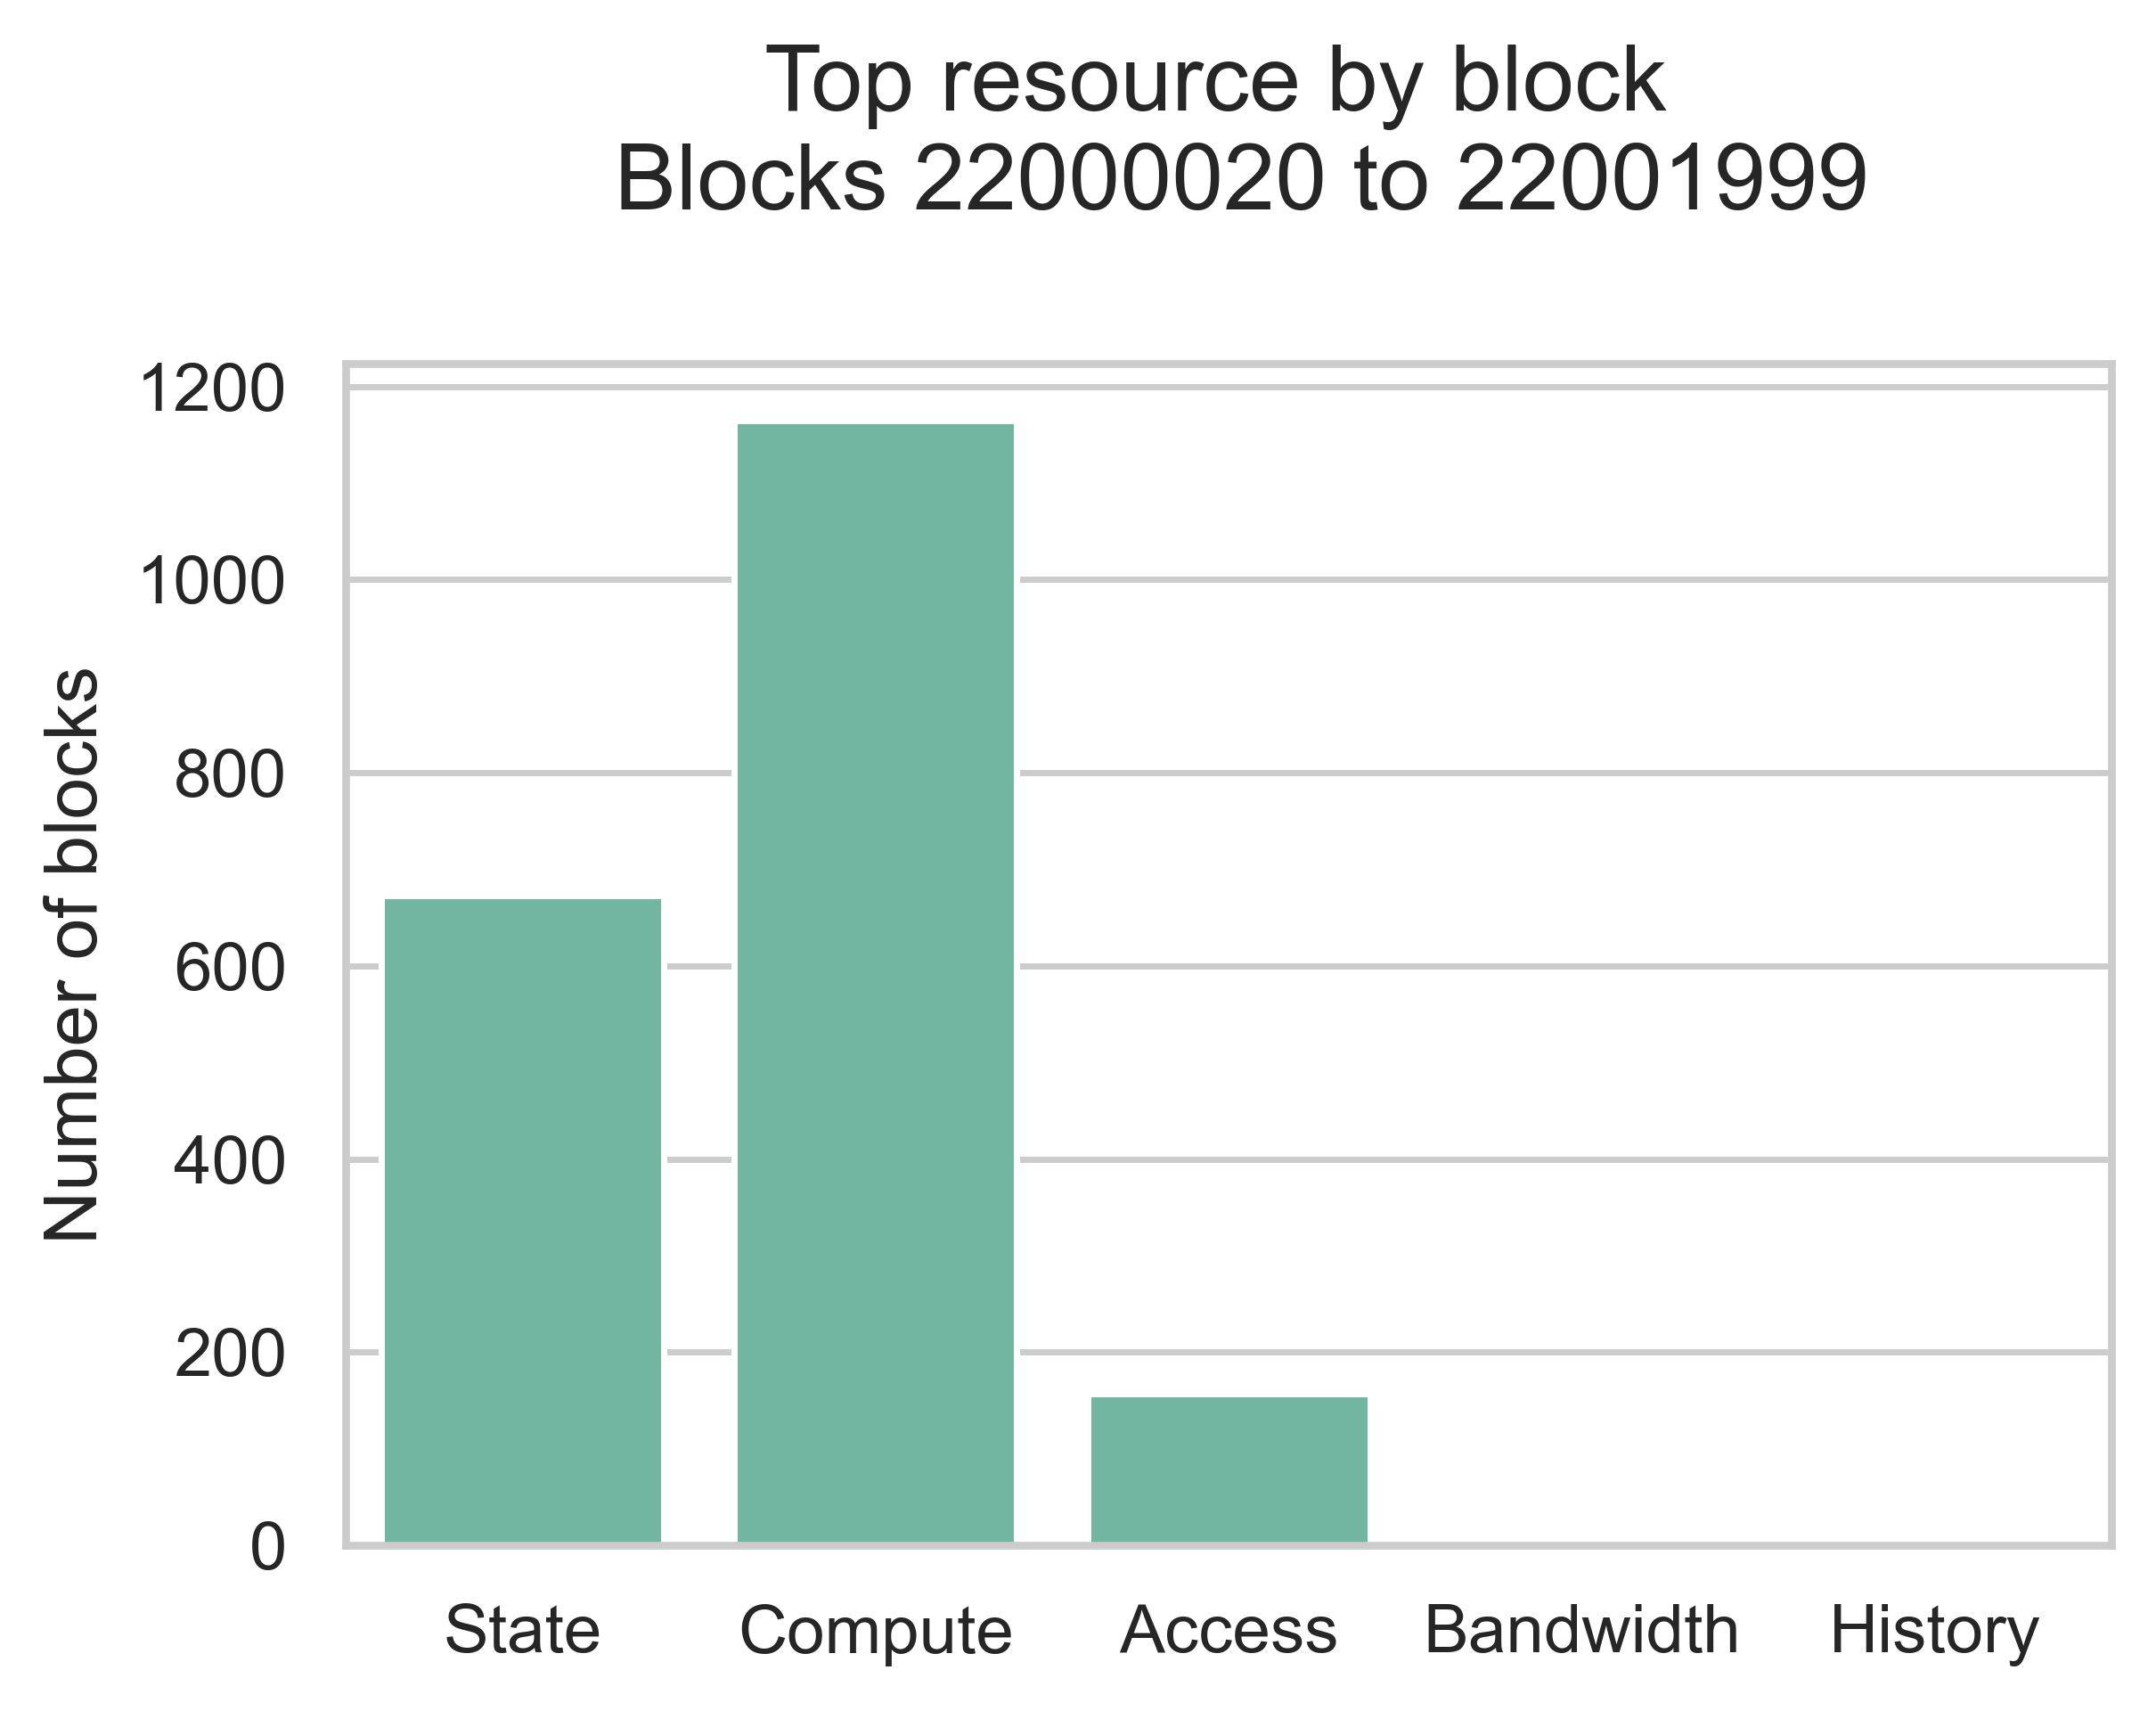

In [37]:
top_resource_df = (
    (totals_df / 36_000_000)
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(5, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    "Top resource by block \n Blocks 22000020 to 22001999",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

## 7. High utilization blocks

In [28]:
resource_by_block_df = totals_df.copy()
resource_by_block_df["Total"] = resource_by_block_df.sum(axis=1)
resource_by_block_df = resource_by_block_df / 36_000_000

Tx %: 42.56384576865298


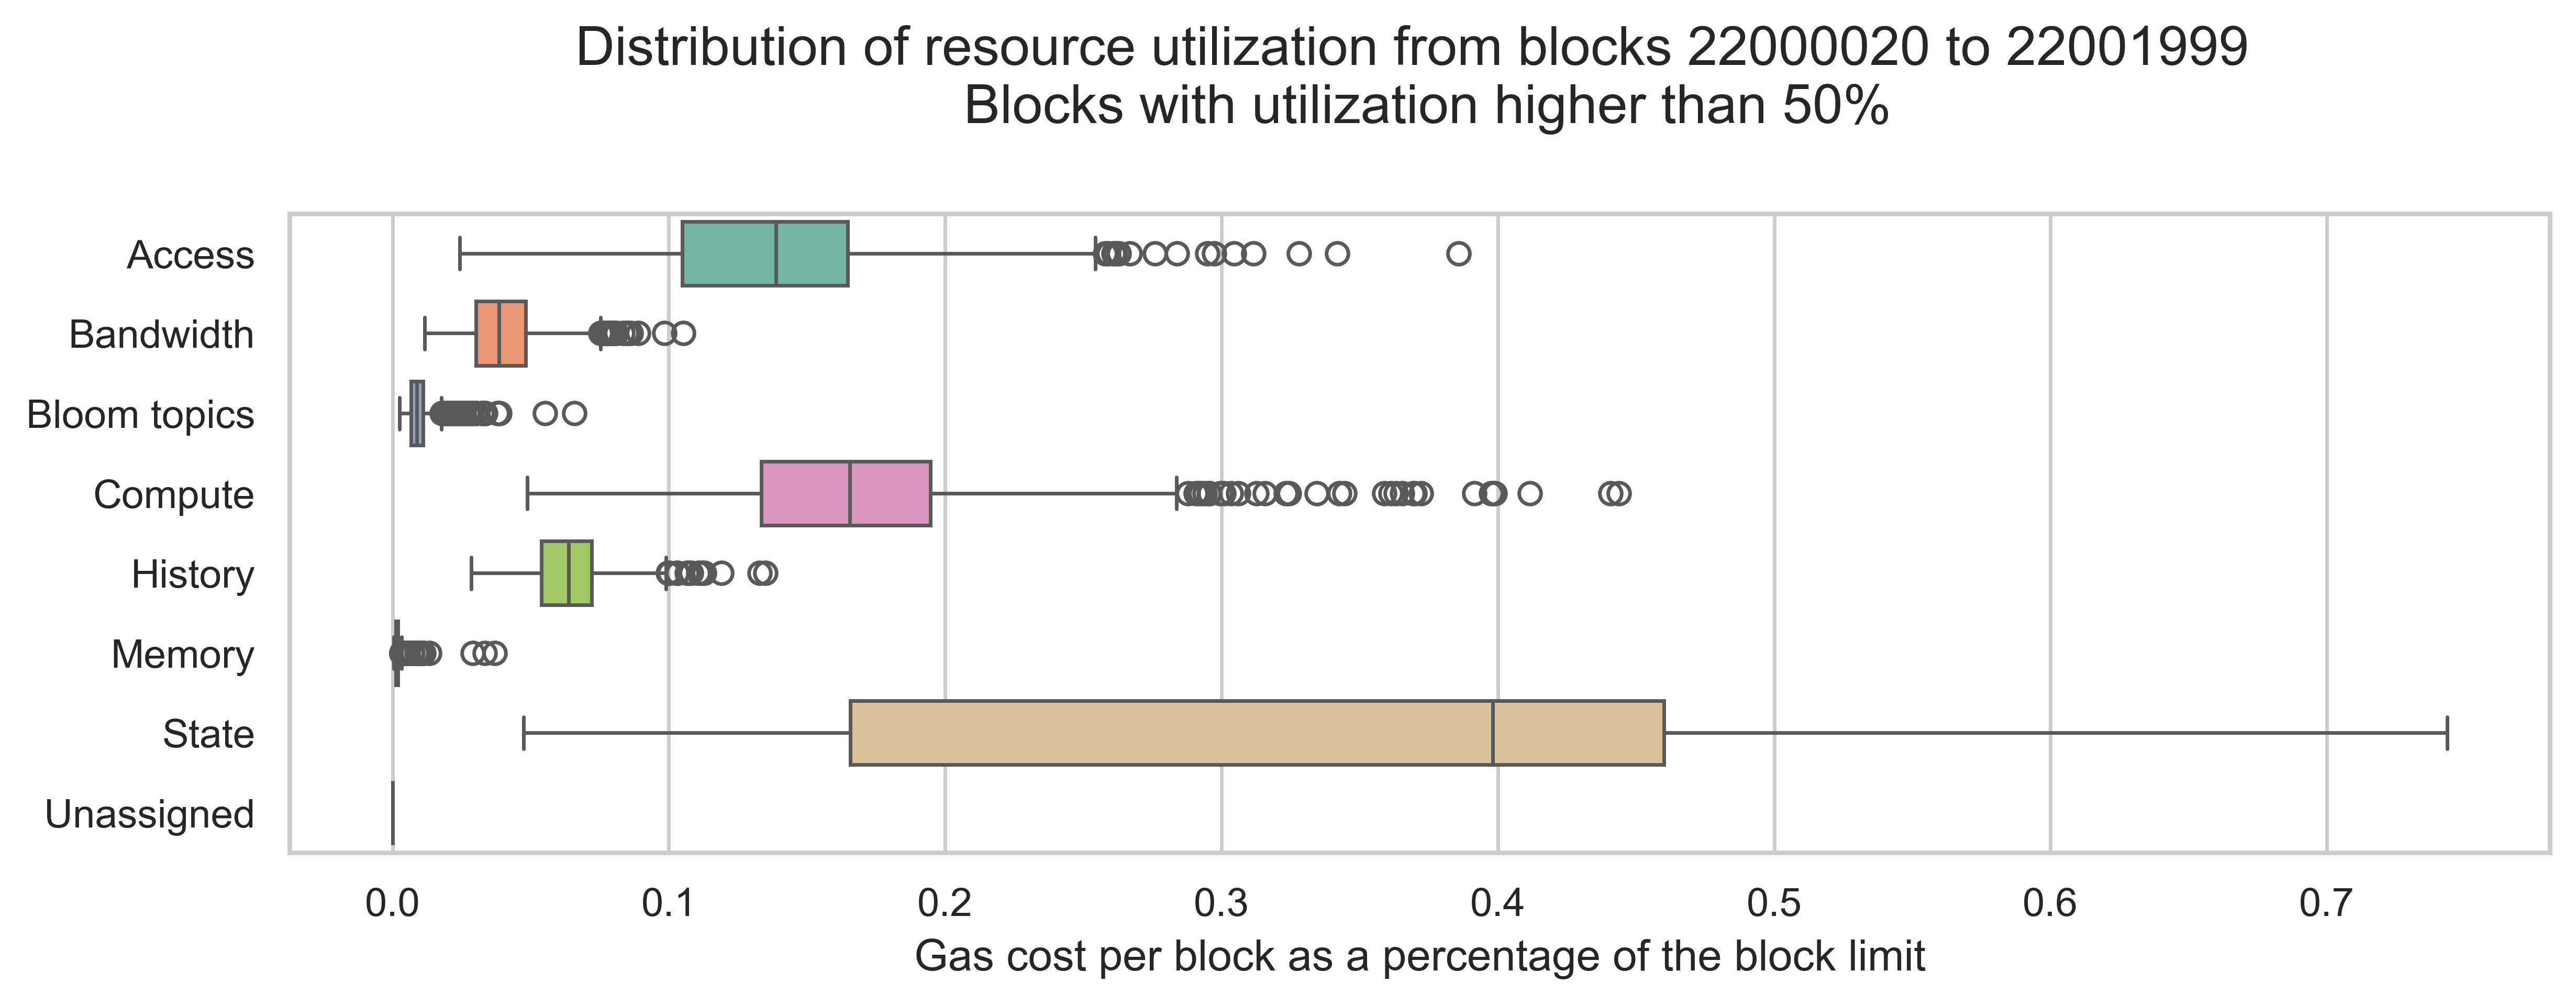

In [29]:
thres = 0.5
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from blocks 22000020 to 22001999 \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

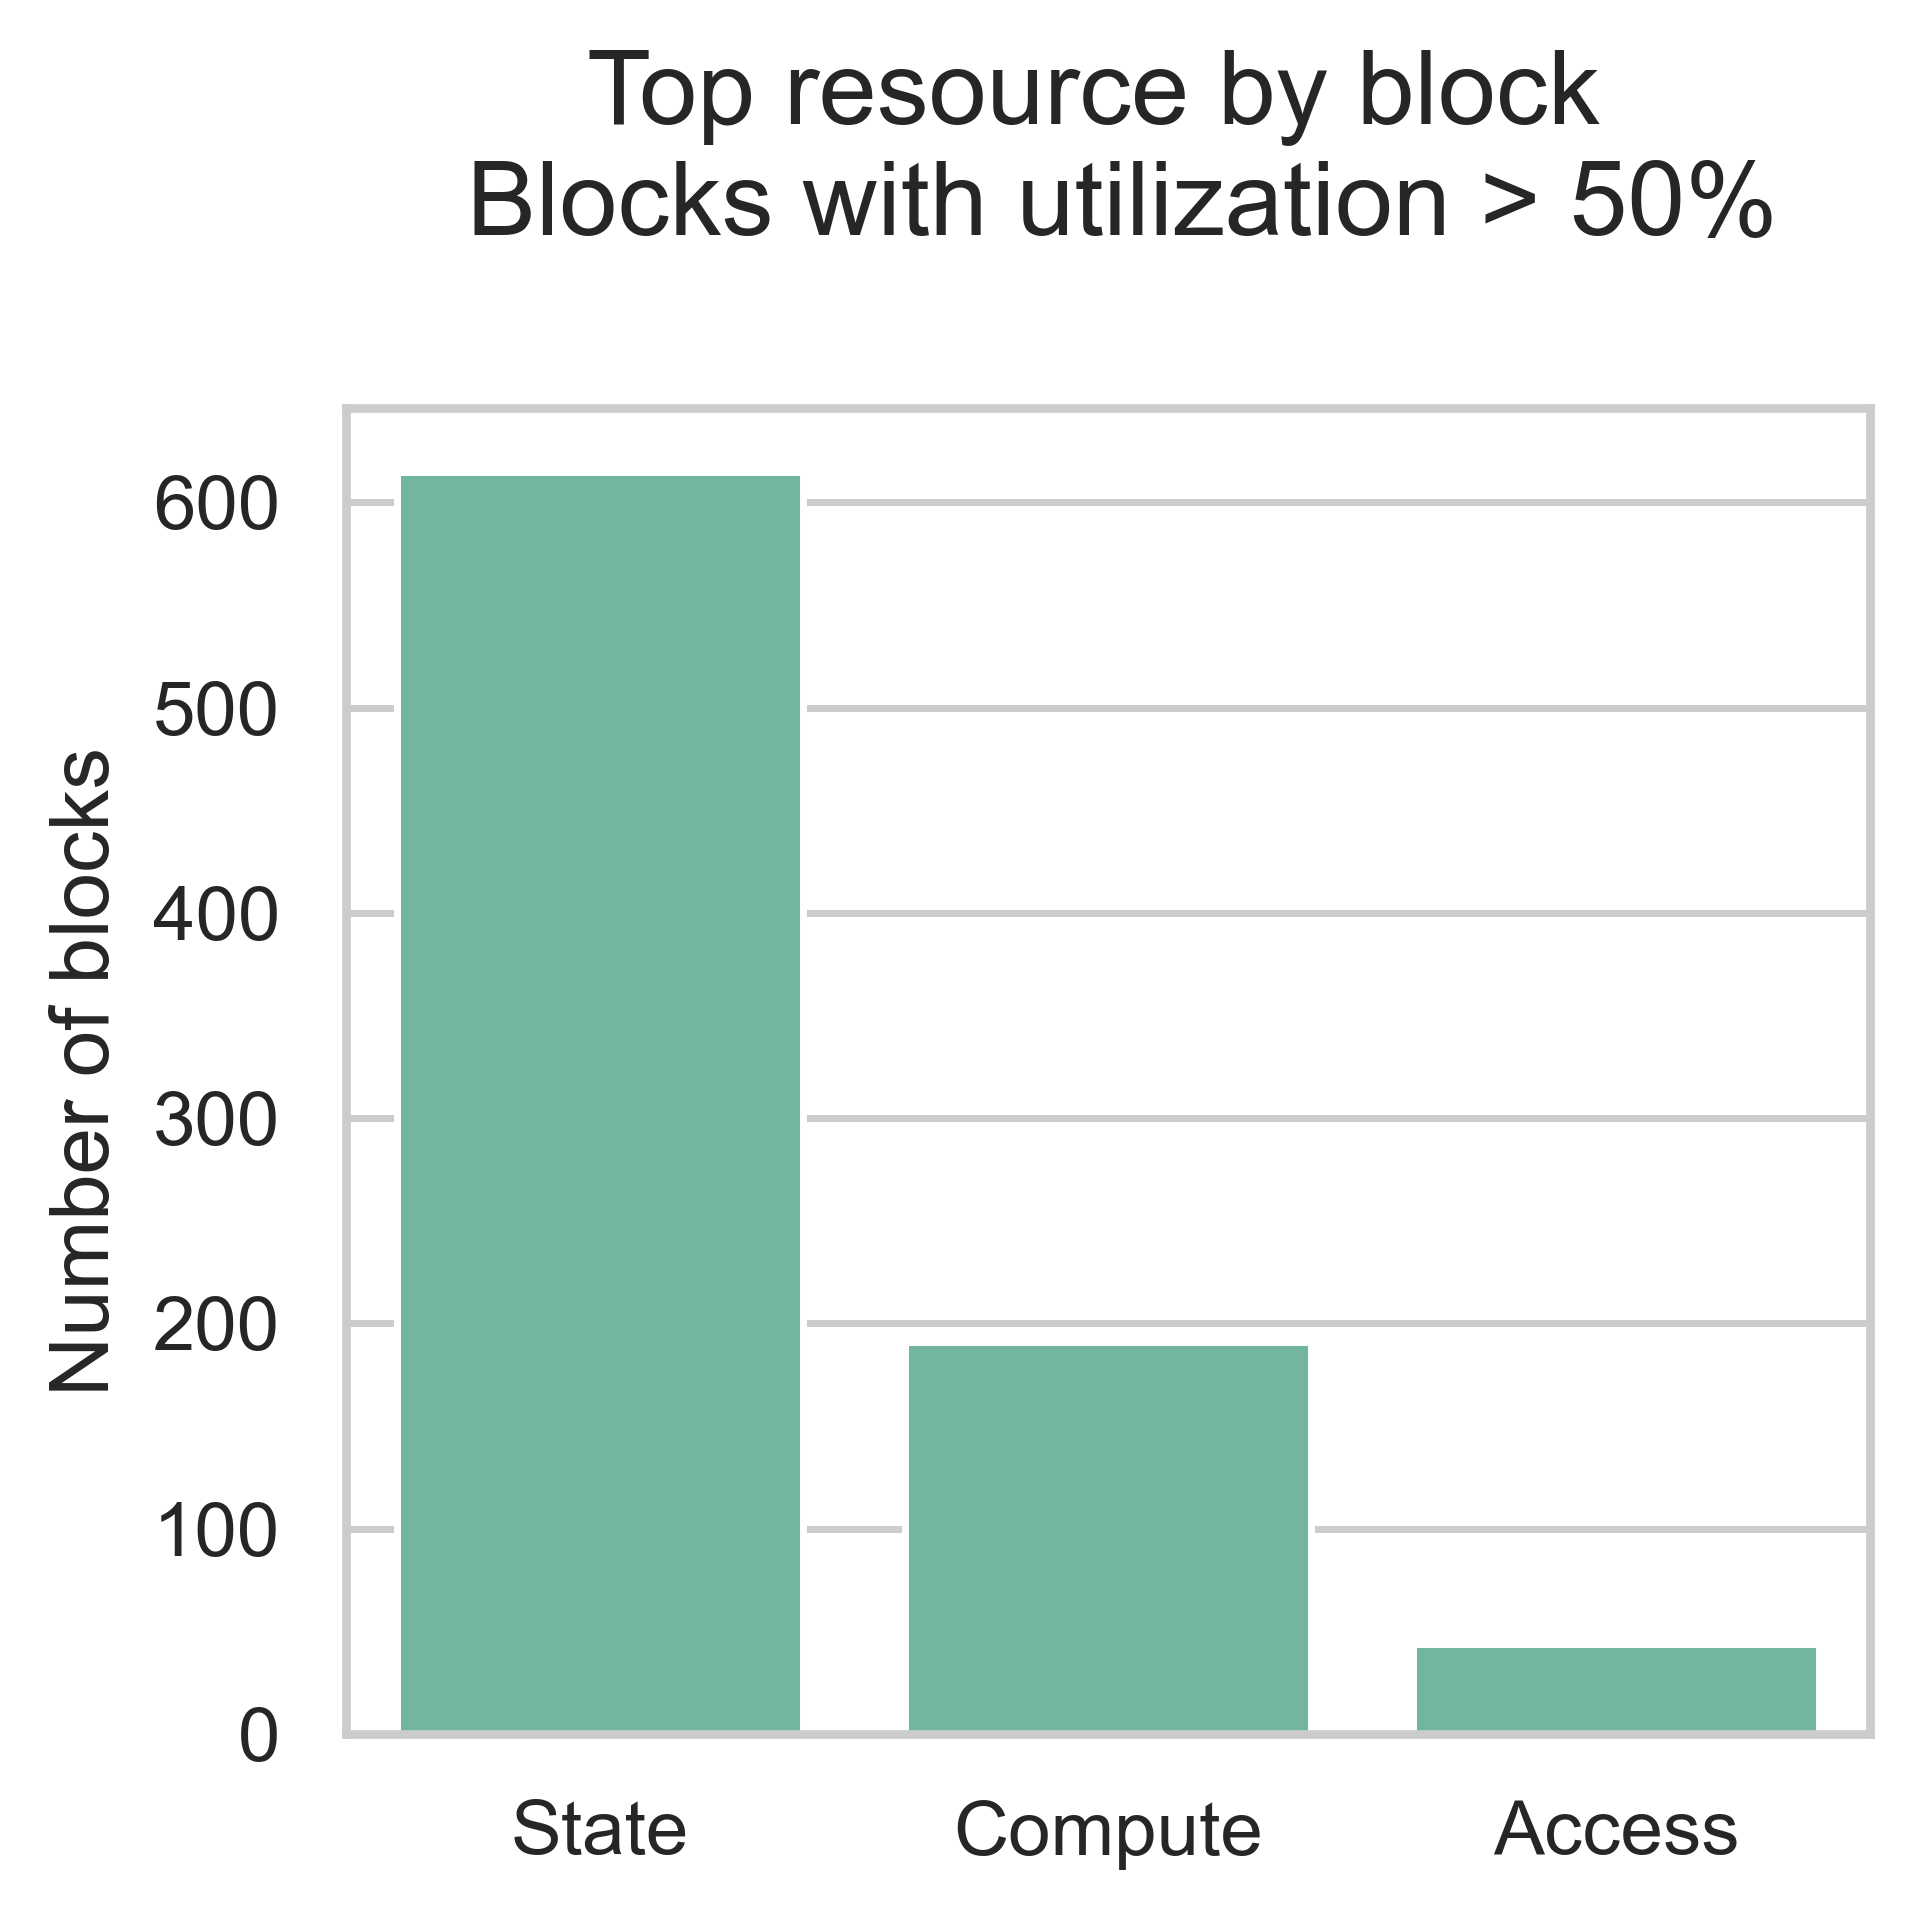

In [39]:
thres = 0.5
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(4, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

Tx %: 19.128693039559337


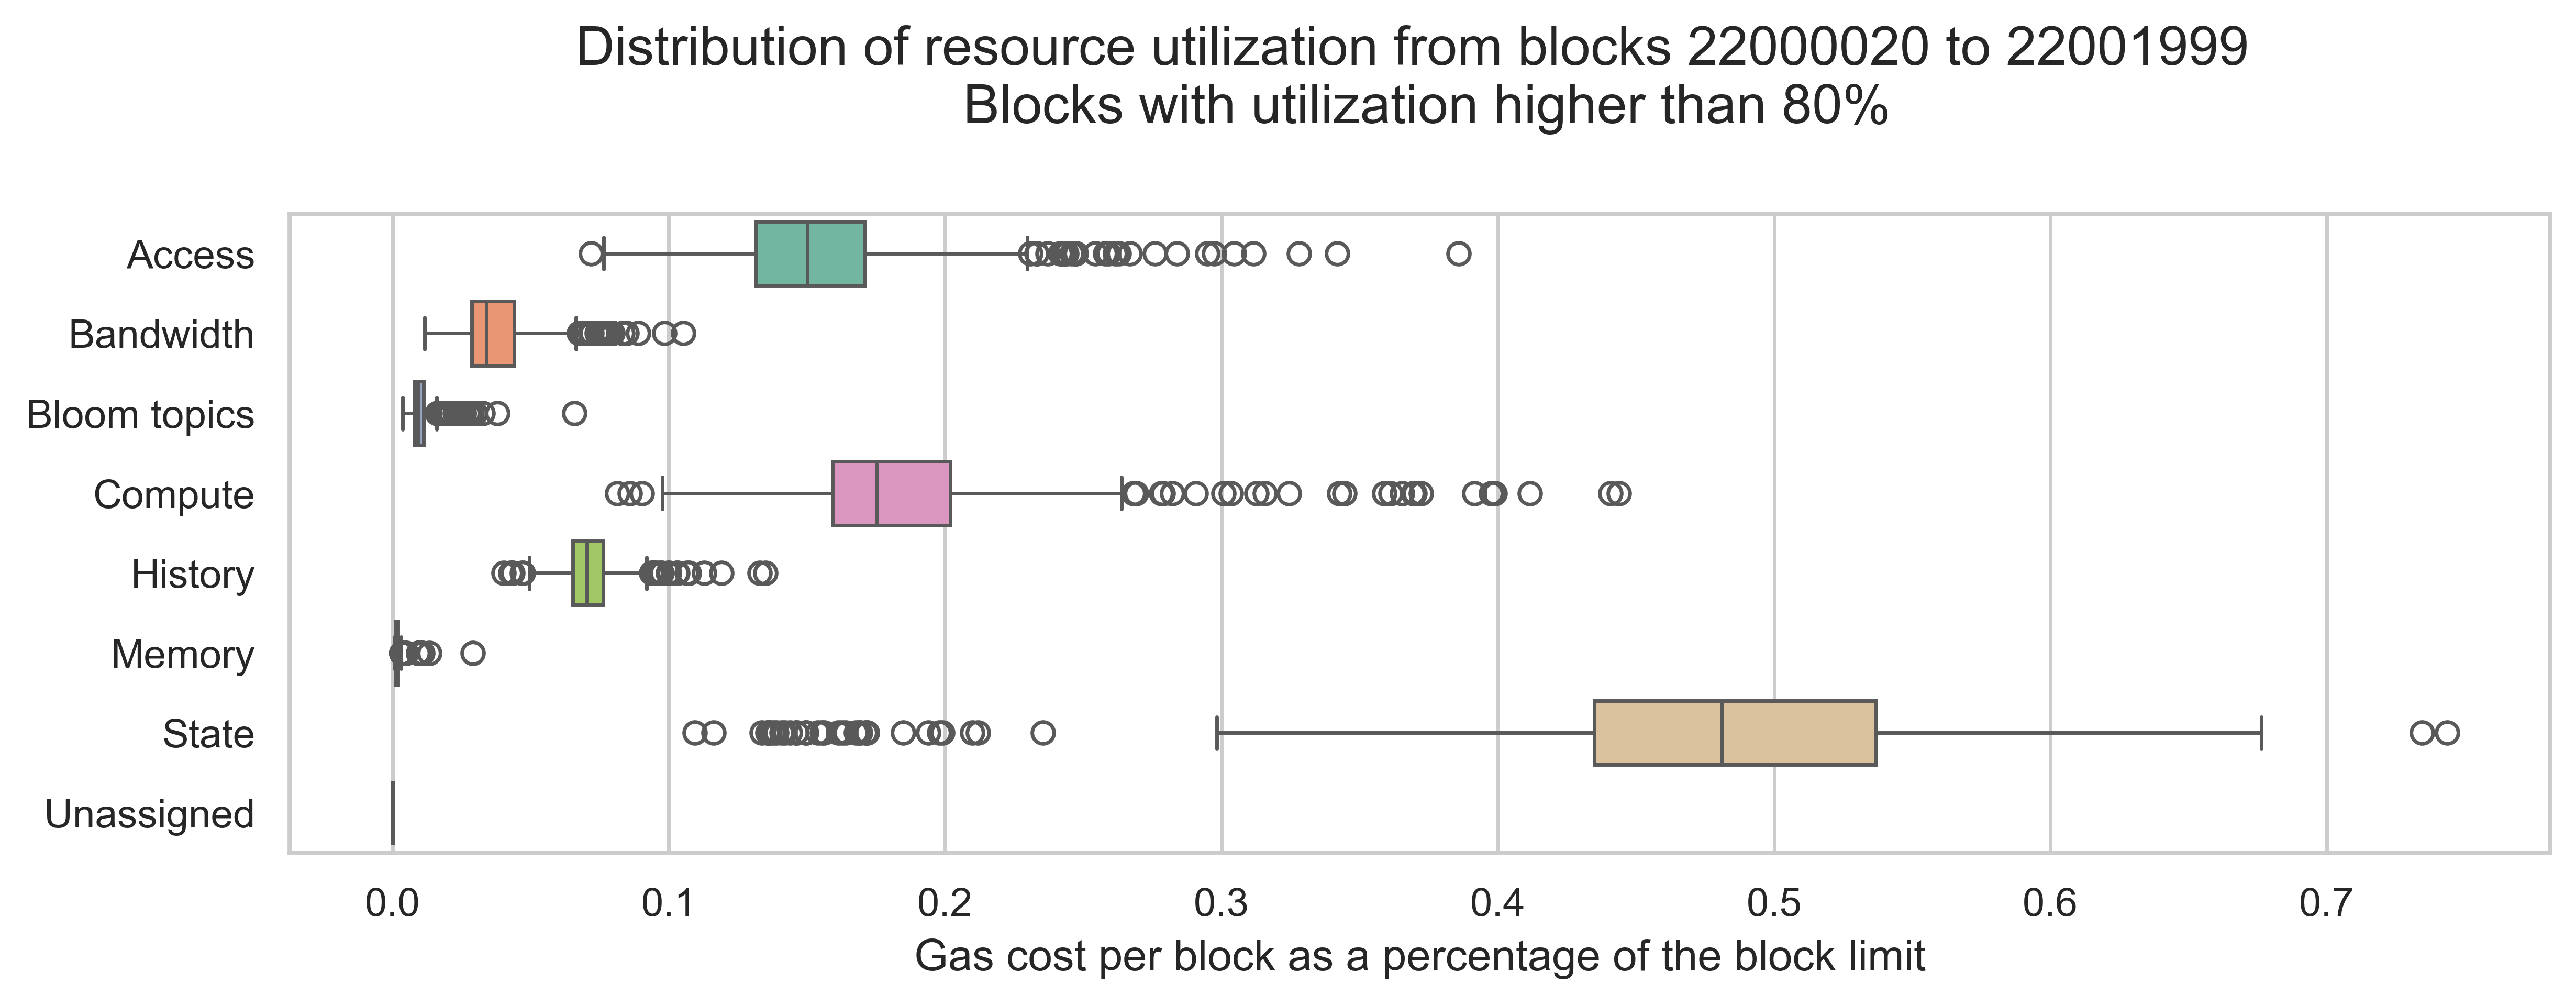

In [31]:
thres = 0.8
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from blocks 22000020 to 22001999 \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

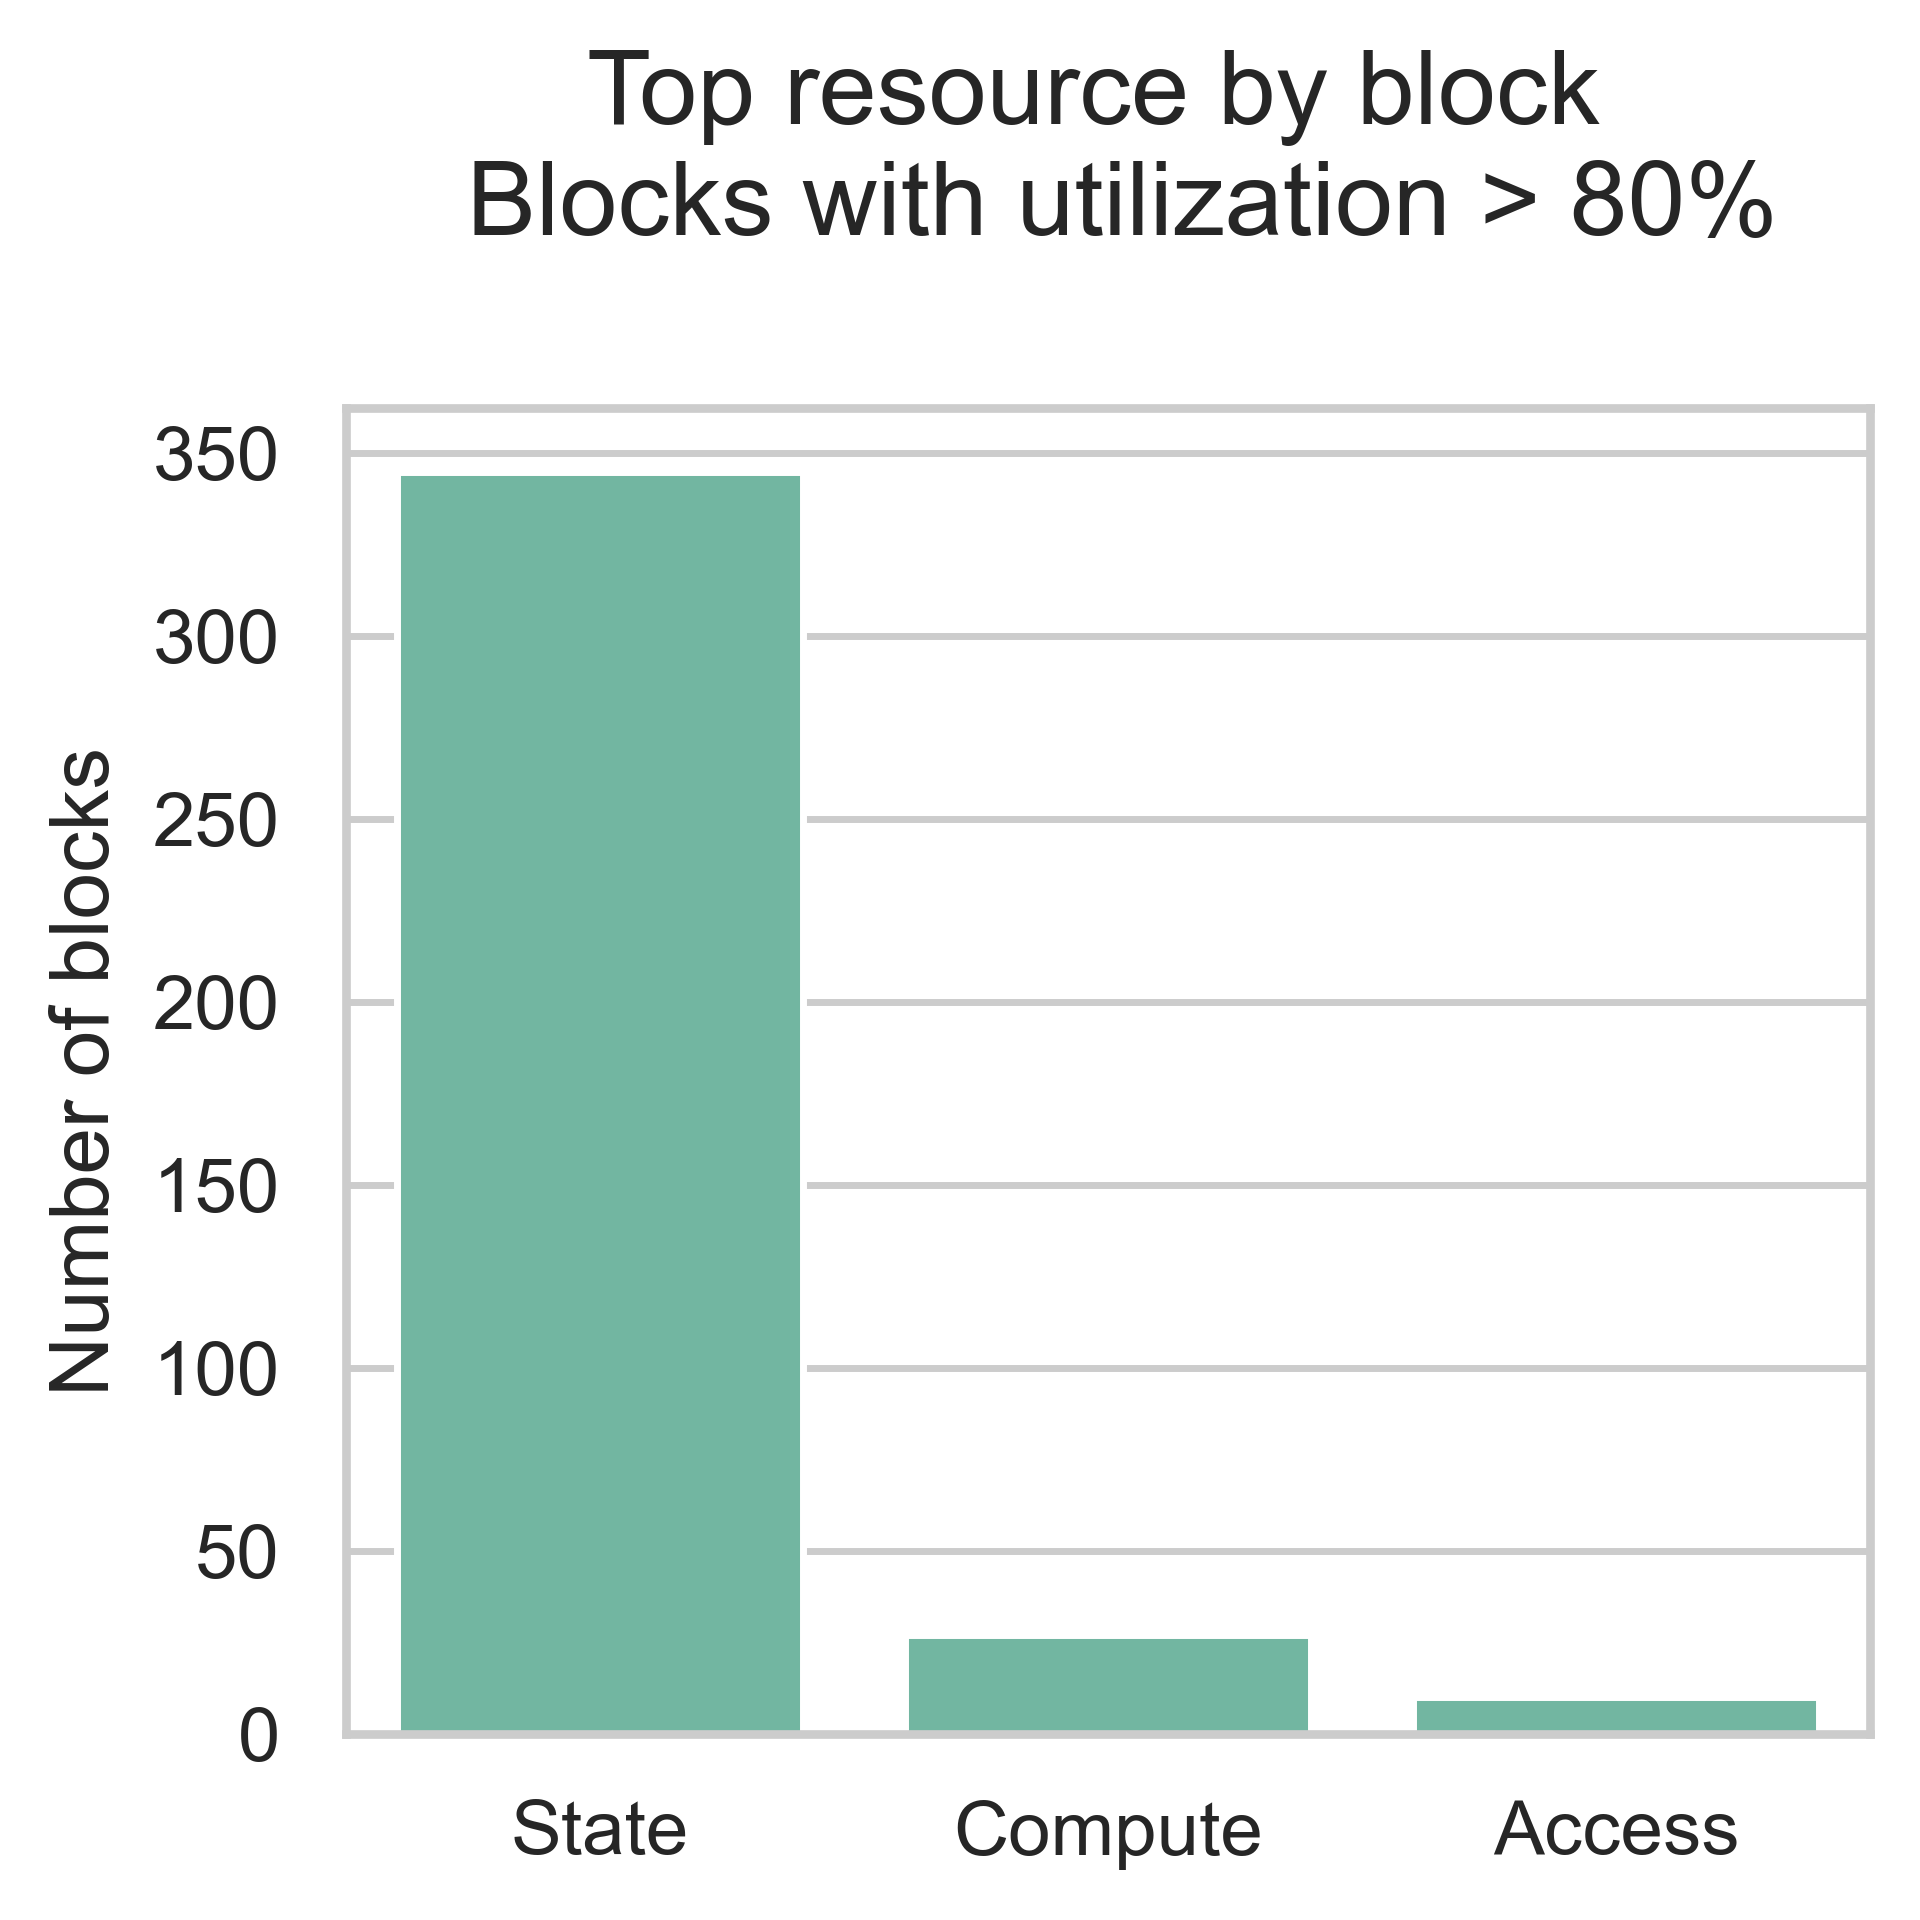

In [32]:
thres = 0.8
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(4, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()

Tx %: 9.564346519779669


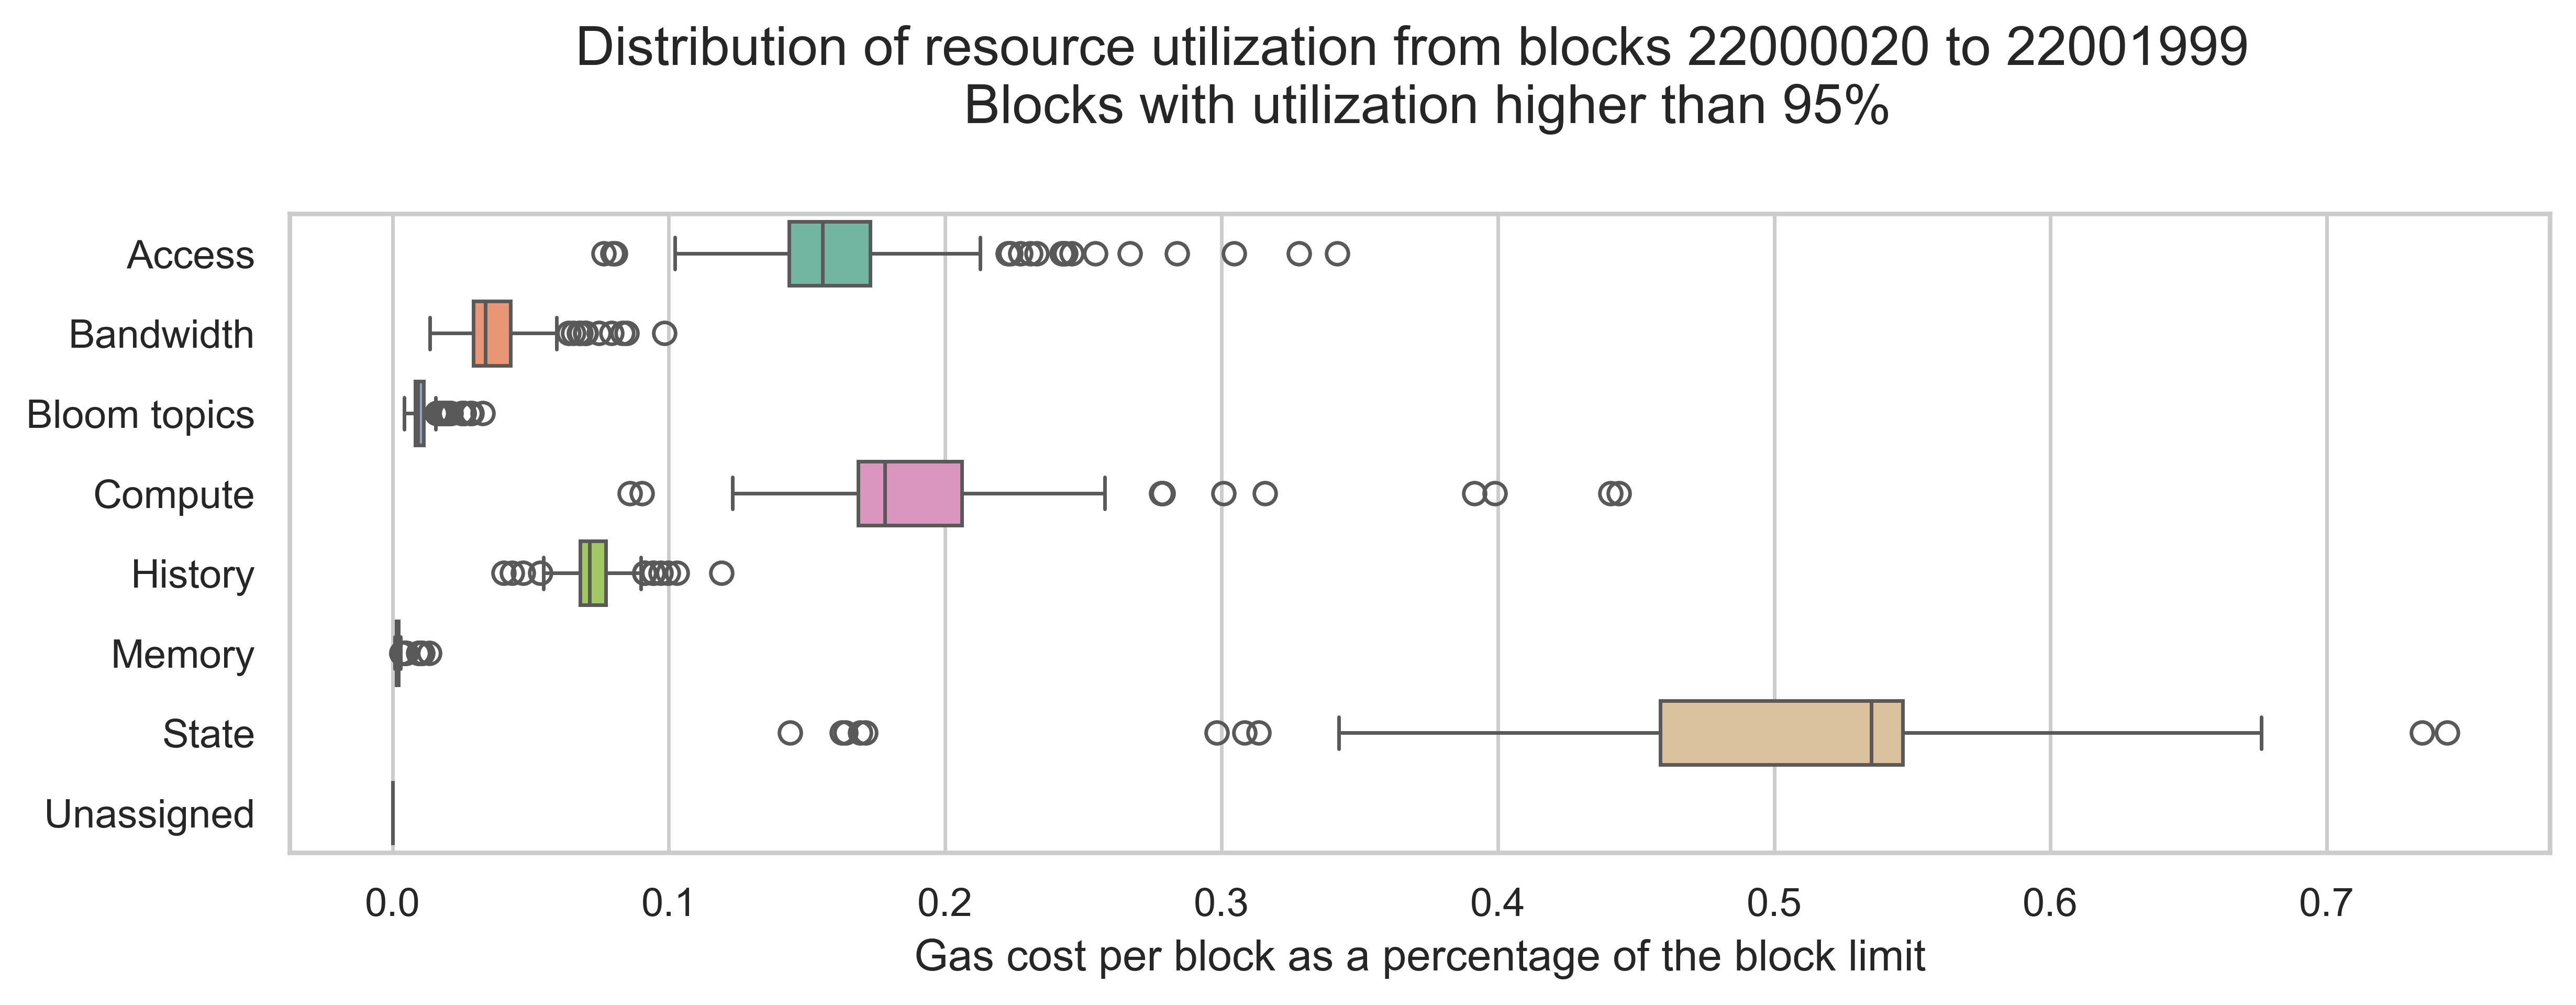

In [33]:
thres = 0.95
high_util_blocks_df = resource_by_block_df[resource_by_block_df["Total"] > thres]
print("Tx %:", 100 * len(high_util_blocks_df) / len(resource_by_block_df))

temp_df = (
    high_util_blocks_df.drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("Resource")
)

plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=temp_df,
    hue="Resource",
    legend=False,
)
plt.title(
    f"Distribution of resource utilization from blocks 22000020 to 22001999 \n Blocks with utilization higher than {int(thres*100)}%",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Gas cost per block as a percentage of the block limit")
plt.tight_layout()
plt.show()

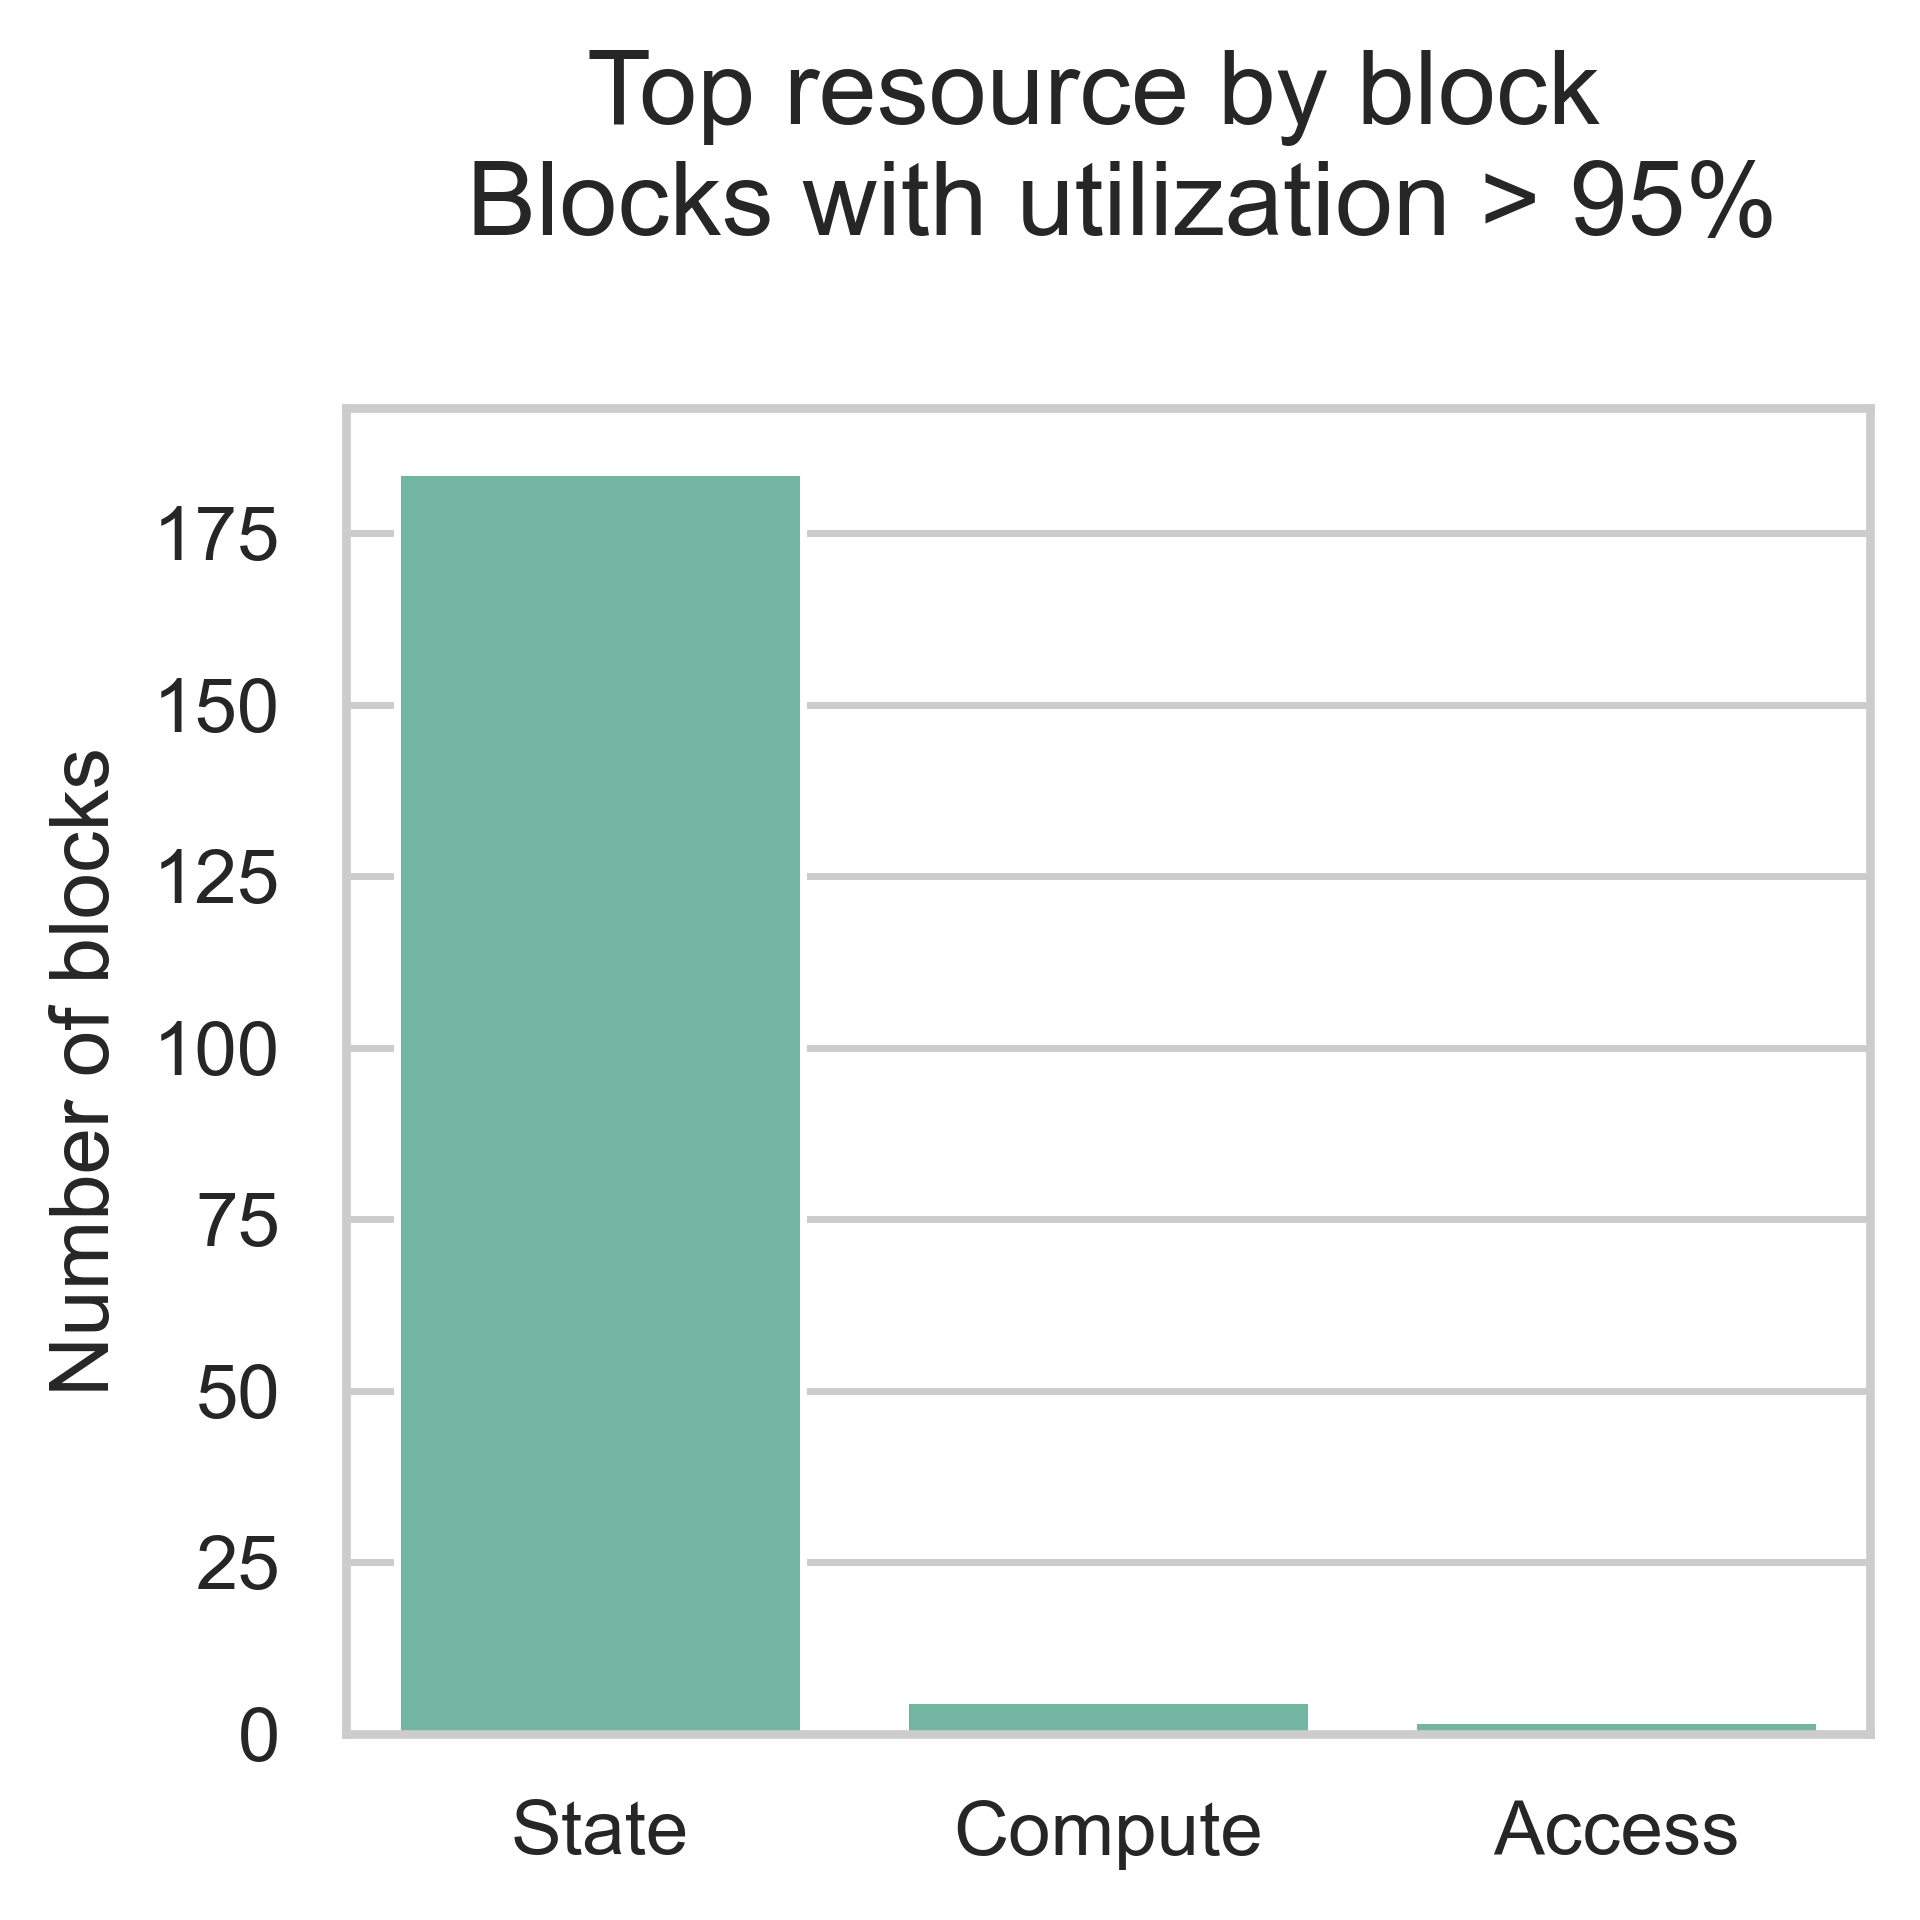

In [34]:
thres = 0.95
top_resource_df = (
    resource_by_block_df[resource_by_block_df["Total"] > thres]
    .drop(columns="Total")
    .reset_index()
    .melt(id_vars=["block_height"], var_name="Resource", value_name="gas_cost")
    .sort_values("gas_cost", ascending=False)
    .groupby("block_height")
    .first()
)
plt.figure(figsize=(4, 4))
sns.countplot(data=top_resource_df, x="Resource")
plt.title(
    f"Top resource by block \n Blocks with utilization > {int(thres*100)}%",
    pad=25,
)
plt.xlabel("")
plt.ylabel("Number of blocks")
plt.tight_layout()
plt.show()